# 신(新) 코로나 지역별 위험지표 제작 및 안전한 길찾기 플랫폼

---

## 주제
- 국민의 안전한 이동을 위해 **전국 코로나 위험도를 의미하는 위험지표**를 나타내고 위험지표 중 큰 비중을 차지하는 **유동인구 데이터를 활용한 안전경로 안내서비스**

- 안내 서비스 웹페이지 : https://dacon-project.du.r.appspot.com/
---

## 목차

### 0. 주제 선정 이유

### 1. 코로나 데이터 전처리 및 EDA 분석

   1. 라이브러리 호출

   2. 데이터 시각화
      
      
### 2. 교통 데이터 전처리 

  1. 서울시 대중교통 이용량 데이터 시각화 

  2. TS교통카드 정류장 이용량(DM_STTN_USEV_SMY) 데이터 전처리    

  3. TS교통카드 정류장(DM_STTN_T.dat) 데이터 전처리

  4. 전처리한 데이터(2.2, 2.3에서 만든)들을 정류장ID로 통합

### 3.대중교통 안전경로 추천 프로세스 제작
   1. 배경

   2. 구현 방안


### 4. 지역별 코로나 위험지표 회귀모델 제작

   1. 길찾기 프로그램 제작
   
   2. 대중교통 Open API인 ODsay와 연동하여 Json파일 받아오기

### 5. AWS Sever 구축 및 주피터 설치


 
### 6. 결론



- Google Colab에서의 코딩을 위한 환경설정 진행

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive/', force_remount=True)
os.chdir("gdrive/My Drive/dacon/COVID_19")

Mounted at /content/gdrive/


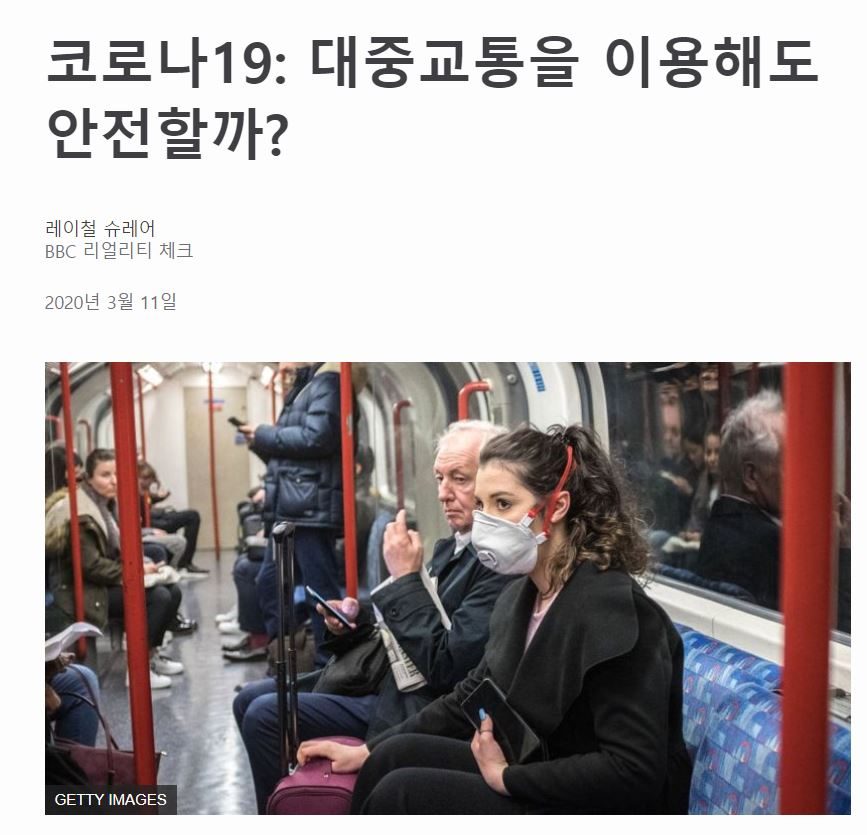

## 0. 주제 선정 이유
- 수도권은 대중교통 이용자가 일 평균 약 800만명에 달한다. 대한민국 인구의 약 5분의 1이 대중교통을 이용하는 셈이다. 이는 곧 국민 대다수가 코로나 위험에 노출되어 있다는 것을 의미한다. 영국 국민건강보험(NHS)의 COVID-19 가이드에 따르면 '근접 접촉'은 감염자 2m 이내에 15분 이상 머무르는 것을 의미한다. 따라서 과거 데이터를 통해 전철과 버스의 **혼잡도를 미리 파악하여 혼잡도가 더 작은 경로를 제공**하는 플랫폼을 제공함으로써 국민들의 감염확률을 줄이고자 한다. 또한 전국 코로나 감염에 **위험한 지표가 될 수 있는 변수들을 찾아 회귀모델을 제작**하여 종속변수가 높게 나오는 지역들을 구분하고 이를 통해 효과적인 방역에 보탬이 되고자 한다.
    
    
  출처 : https://www.bbc.com/korean/news-51829809, "코로나19: 대중교통을 이용해도 안전할까?", 레이철 슈레어

# 1. 코로나 데이터 전처리 및 EDA 분석

## 1.1 라이브러리 호출

In [ ]:
# !pip install folium
# !pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install --user
# %config InlineBackend.figure_format = 'retina'
# !apt -qq -y install fonts-nanum
# !pip install haversine
# !pip install plotly_express
# !pip install geopandas
# !pip install mapboxgl
# !pip install mapclassify

In [ ]:
import mapboxgl
import folium
import matplotlib.font_manager as fm
import seaborn as sns
import mapclassify
import json
import requests
import datetime as dt
import pandas as pd
import numpy as np
import geopandas as gpd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import plotly_express as px
import matplotlib as mpl
import matplotlib.font_manager as fm
import warnings
import os
import re
from random import *
from geopandas import GeoDataFrame
from sklearn.preprocessing import MaxAbsScaler,RobustScaler
import statsmodels.formula.api as sm 
import random
import seaborn as sns
import matplotlib.pyplot as plt
from haversine import haversine
from sklearn.linear_model import LinearRegression # 선형회귀모델 생성 
from sklearn.model_selection import train_test_split # train/test set 생성 
from sklearn.metrics import mean_squared_error # MSE : 평균제곱오차 - model 평가 

warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1.2 데이터 시각화
- 데이터 불러오기

In [ ]:
Region = pd.read_csv('Region.csv')
Gender = pd.read_csv('TimeGender.csv') 
covid_case = pd.read_csv('Case.csv')
Patient = pd.read_csv('PatientInfo.csv')


Region.head()

,code,province,city,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
0,10000,서울,서울,37.566953,126.977977,607,830,48,1.44,15.38,5.8,22739
1,10010,서울,강남구,37.518421,127.047222,33,38,0,4.18,13.17,4.3,3088
2,10020,서울,강동구,37.530492,127.123837,27,32,0,1.54,14.55,5.4,1023
3,10030,서울,강북구,37.639938,127.025508,14,21,0,0.67,19.49,8.5,628
4,10040,서울,강서구,37.551166,126.849506,36,56,1,1.17,14.39,5.7,1080


#### 일별 성별별 누적 확진자 및 사망자 추이
    
- 여성 확진자가 남성 확진자보다 더 많으나 사망자는 남자가 더 많다.

In [ ]:
# date 열을 데이터타임으로 변환 후 인덱스로 설정
Gender.date = pd.to_datetime(Gender.date)

Gender = Gender.set_index('date')

male = Gender.loc[Gender['sex'] == 'male',:]
female = Gender.loc[Gender['sex'] == 'female',:]

In [ ]:
# 그래프 한글 환경 설정
%config InlineBackend.figure_format = 'retina'
 
# !apt -qq -y install fonts-nanum

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()


# 그래프에 쓰일 폰트 및 사이즈 지정
#font_location = 'C:/Users/ajou/Documents/NanumGothic.ttf'
#fprop = fm.FontProperties(fname=font_location)

#plt.rcParams['font.family'] = 'NanumGothic'
#plt.rcParams['font.size'] = 16
#plt.rcParams['figure.figsize'] = (20,10)

- 일별 누적 확진자 추이 그래프

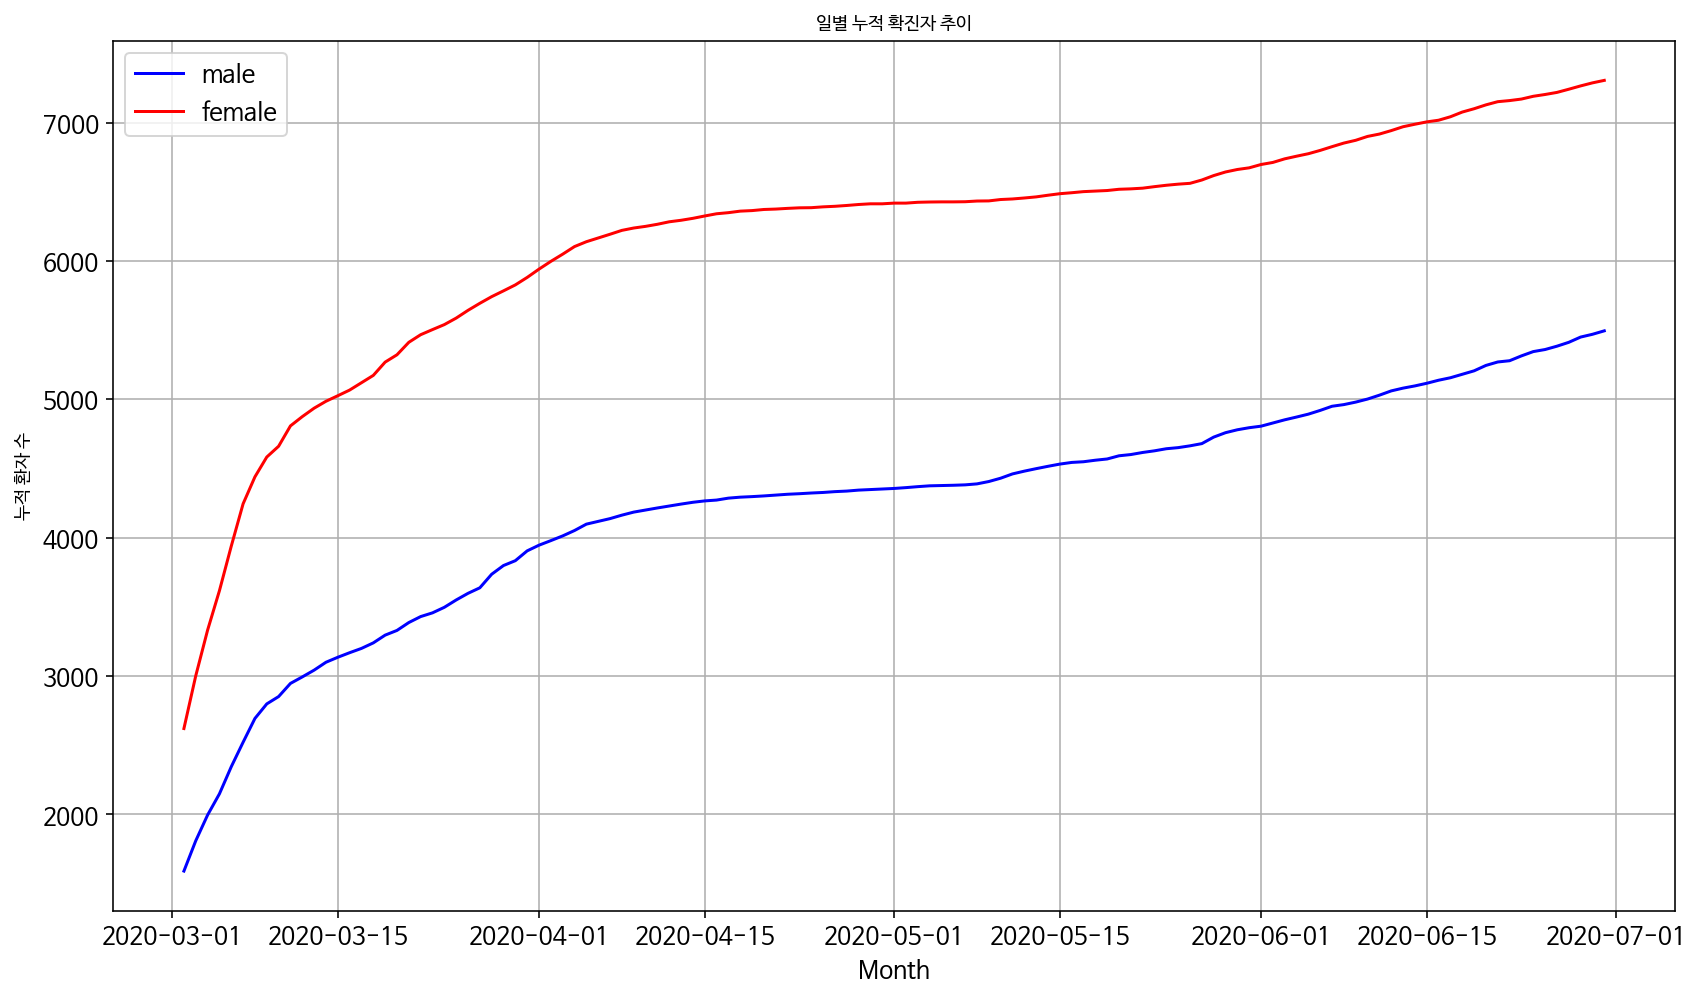

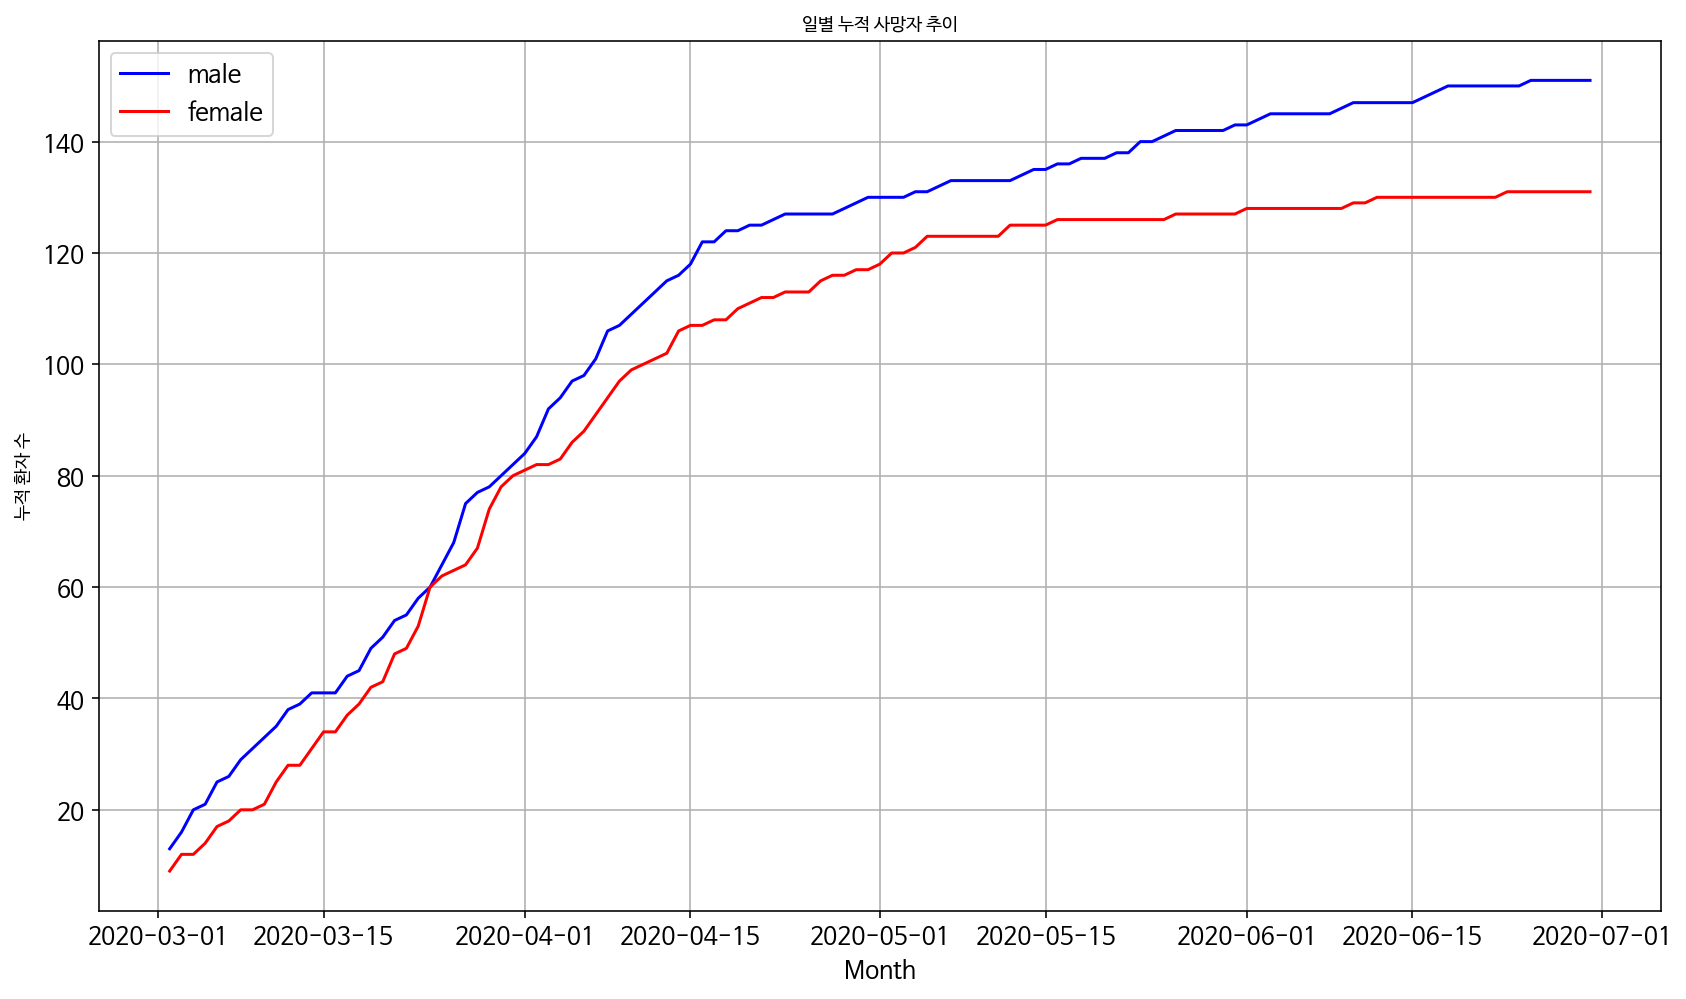

In [ ]:
# 그래픽 크기 설정
plt.rcParams['font.size'] = 12
plt.rcParams["figure.figsize"] = (14,8)

plt.plot(male['confirmed'],'b',label='male')
plt.plot(female['confirmed'],'r',label='female')
plt.grid()
plt.legend()
plt.title('일별 누적 확진자 추이',fontproperties=font)
plt.xlabel('Month')
plt.ylabel('누적 환자 수',fontproperties=font)
plt.show()

plt.plot(male['deceased'],'b',label='male')
plt.plot(female['deceased'],'r',label='female')
plt.grid()
plt.legend()
plt.title('일별 누적 사망자 추이',fontproperties=font)
plt.xlabel('Month')
plt.ylabel('누적 환자 수',fontproperties=font)
plt.show()

- 지역별 확진자 발생현황 그래프

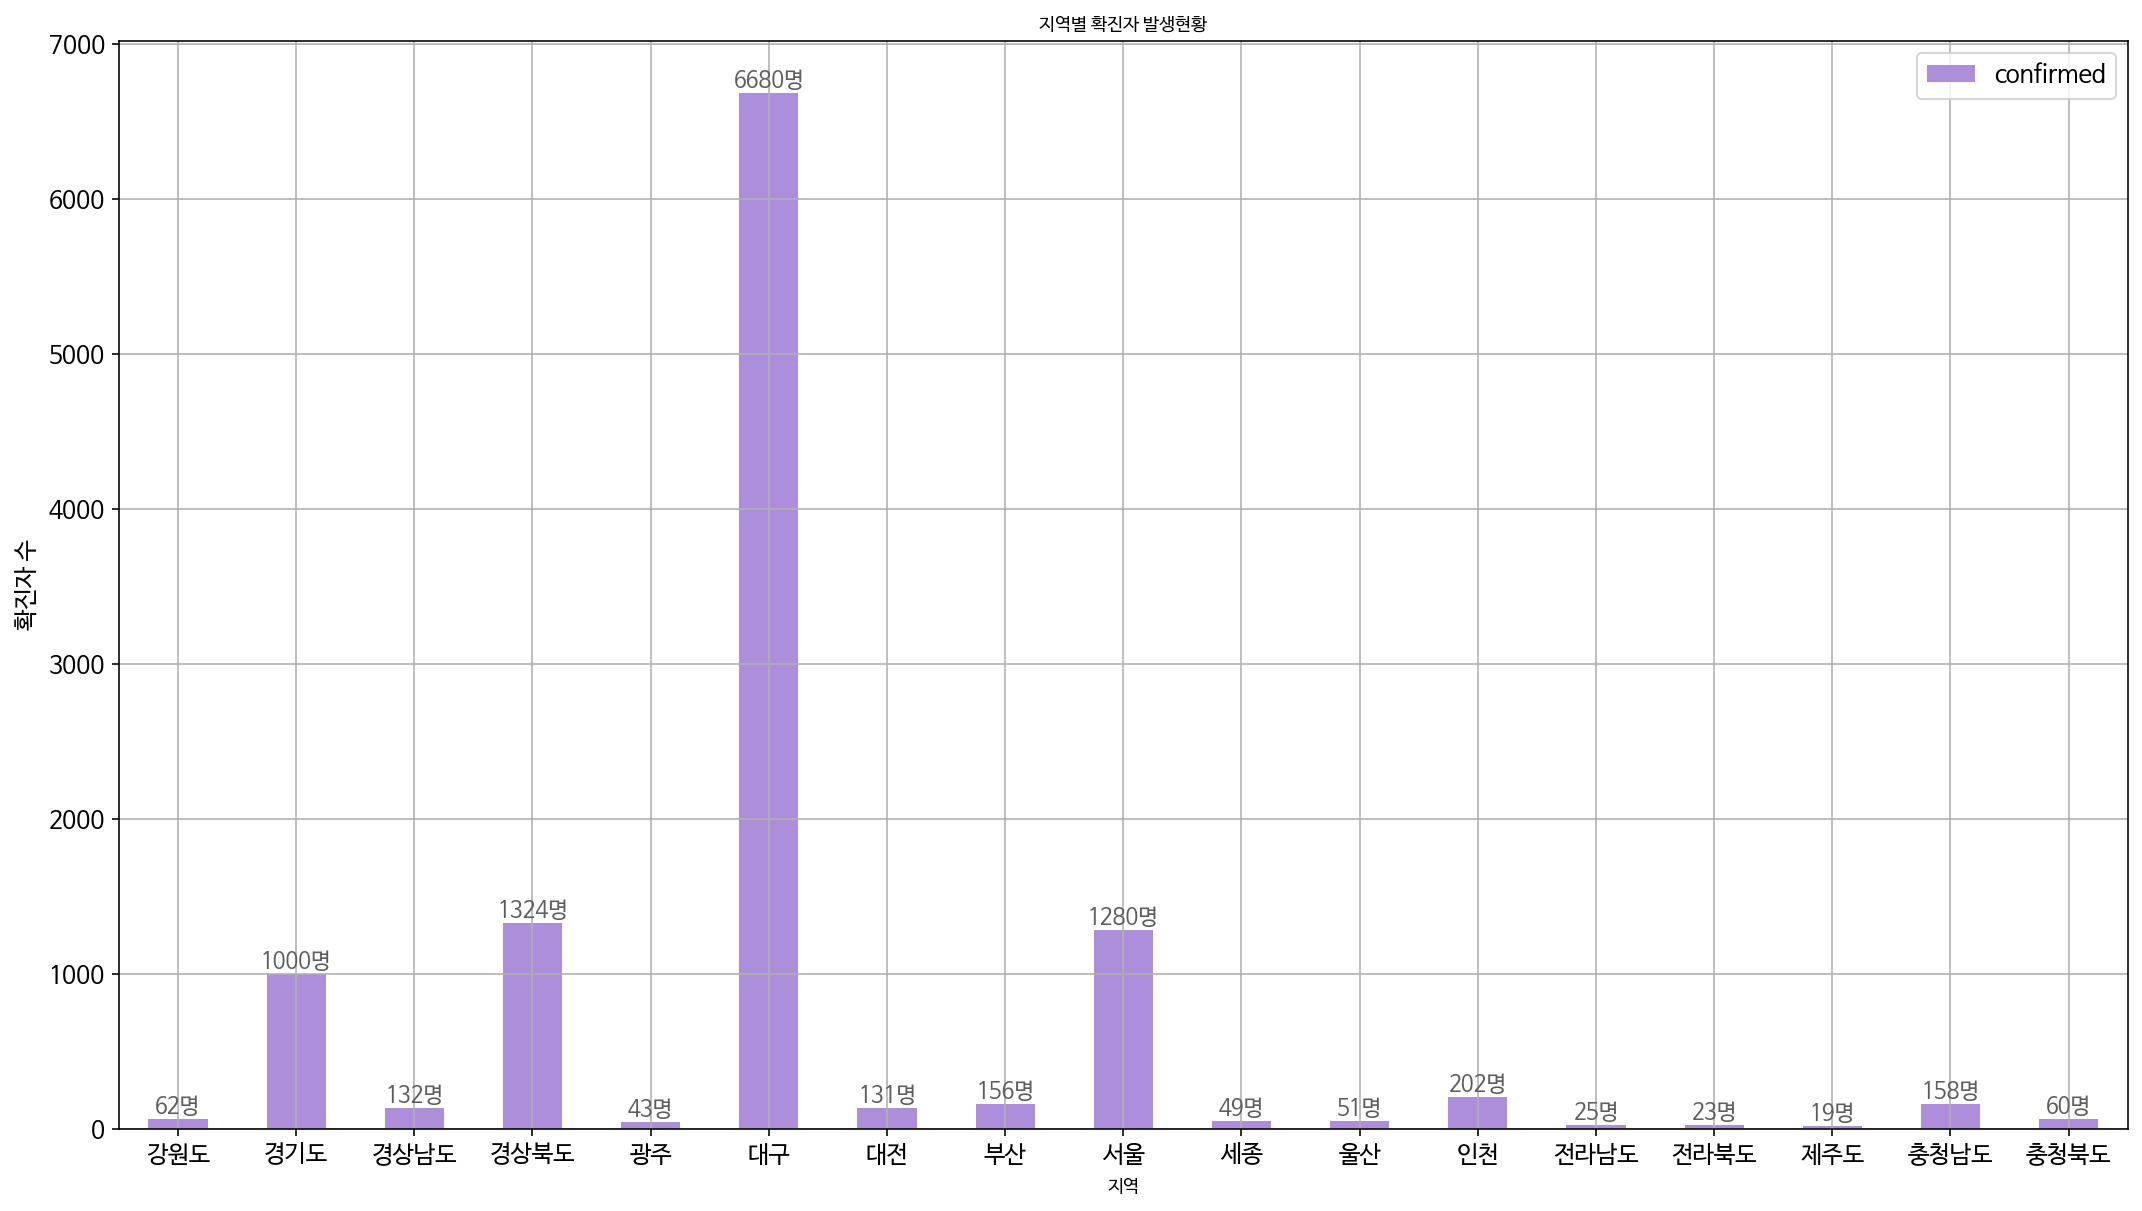

In [ ]:
# 그래픽 크기 설정
plt.rcParams["figure.figsize"] = (18, 10)

sum_tmp = covid_case.filter(['province', 'confirmed'])
province_sum = sum_tmp.groupby(['province']).sum()

# 지역별 확진자 발생현황 Bar 그래프 생성
province_sum['confirmed'].plot.bar(color='#AD8EDB', rot=0, width=0.5)
plt.grid()
plt.legend()
plt.title("지역별 확진자 발생현황",fontproperties=font)
plt.xlabel("지역",fontproperties=font)
plt.ylabel("확진자 수")
xpos = np.arange(len(province_sum.index))
plt.xticks(xpos,list(province_sum.index))

for x,y in enumerate(list(province_sum['confirmed'])):
    num = "%d명"%y
    plt.text(x, y, num, fontsize=11, color='#5D5D5D', horizontalalignment='center', verticalalignment='bottom')

plt.show()

- 지역별 집단 감염 발생현황 그래프

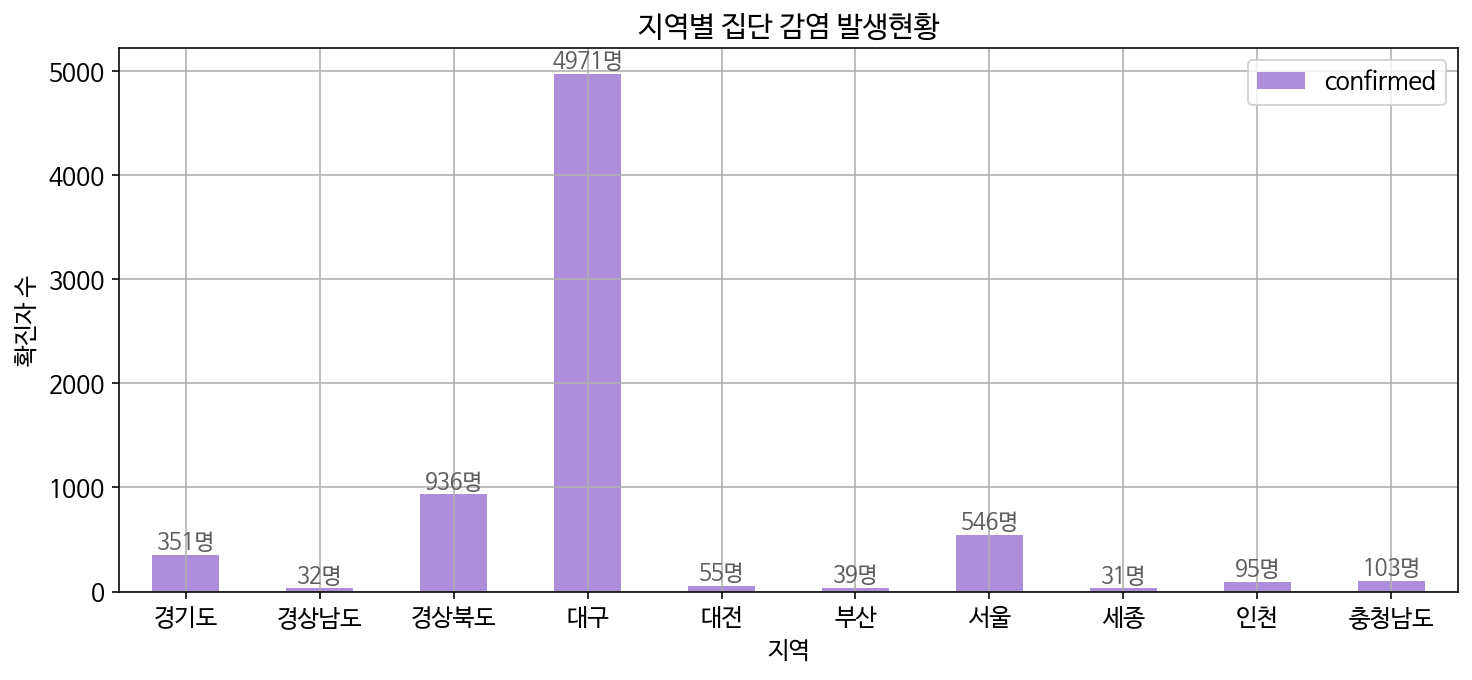

In [ ]:
# 그래픽 크기 설정
plt.rcParams["figure.figsize"] = (12, 5)

# 집단 감염이 많이 일어난 지역을 기준으로 데이터 분할
covid_group_tmp = covid_case[covid_case.group==True]
covid_group = covid_group_tmp[covid_group_tmp.confirmed>=30]
covid_group

# 집단 감염이 많이 일어난 지역 파악을 위한 그래프 출력 (한번에 30명 이상의 집단 감염이 있었던 사례)
group_sum_tmp = covid_group.filter(['province', 'confirmed'])
group_province_sum = group_sum_tmp.groupby(['province']).sum()

group_province_sum['confirmed'].plot.bar(color='#AD8EDB', rot=0, width=0.5)
plt.grid()
plt.legend()
plt.title("지역별 집단 감염 발생현황")
plt.xlabel("지역")
plt.ylabel("확진자 수")
xpos = np.arange(len(group_province_sum.index))
plt.xticks(xpos,list(group_province_sum.index))

for x,y in enumerate(list(group_province_sum['confirmed'])):
    num = "%d명"%y
    plt.text(x, y, num, fontsize=11, color='#5D5D5D', horizontalalignment='center', verticalalignment='bottom')

plt.show()

- 집단 감염 사례 2위 ~ 6위 그래프
   - 집단 감염 사례의 압도적인 비중을 신천지 사태가 차지하므로 이를 제외한 결과의 분포를 확인한다.

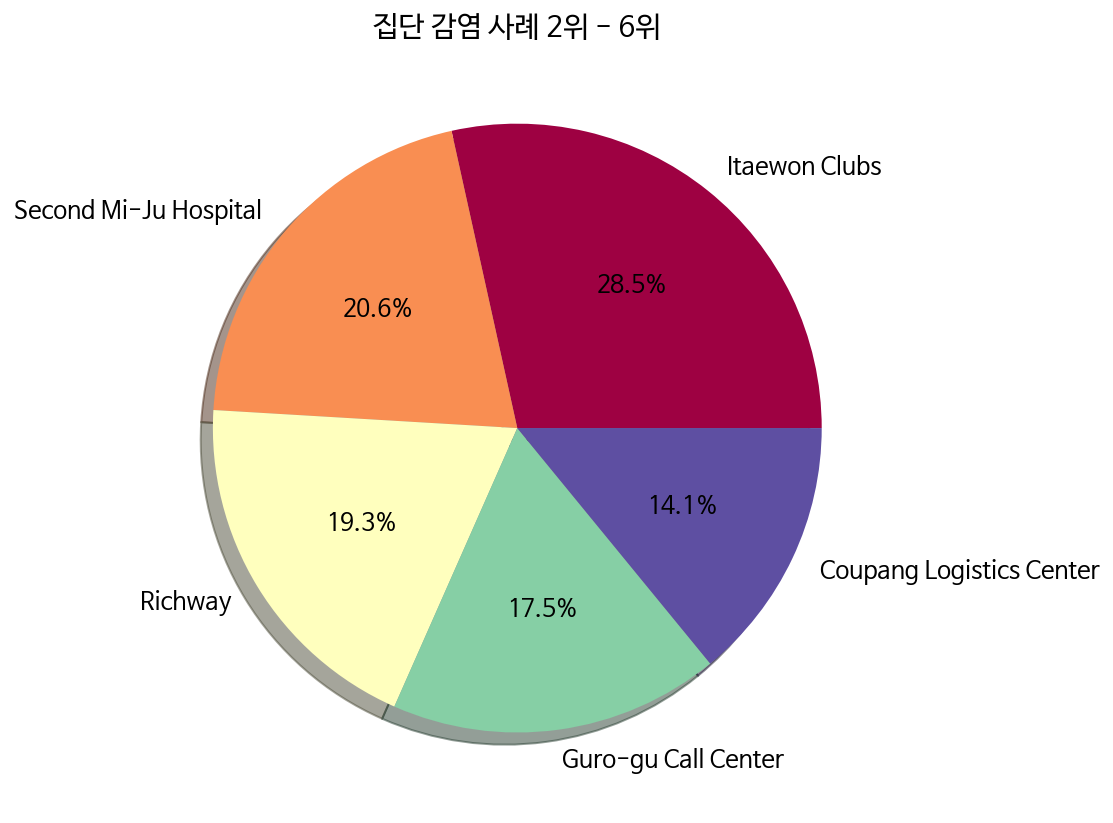

In [ ]:
# 그래픽 크기 설정
plt.rcParams["figure.figsize"] = (15, 7)

# 집단 감염 사례 상위 6개 확인
groupcase = covid_group_tmp.filter(['infection_case', 'confirmed'])
groupcase_tmp = groupcase.groupby(['infection_case']).sum()

groupcase_top6 = groupcase_tmp.sort_values('confirmed',ascending=False).head(6)

# 신천지 사례는 이미 독보적이므로 그를 제외한 다섯 가지 사례에 대한 pie chart 생성
groupcase_top = groupcase_top6.iloc[1:7,:]

c_map = plt.get_cmap('Spectral')
col = [c_map(i) for i in np.linspace(0, 1, 5)]

plt.title("집단 감염 사례 2위 - 6위")
plt.pie(groupcase_top.confirmed, labels=list(groupcase_top.index), autopct='%1.1f%%', shadow=True, colors=col)
plt.show()

In [ ]:
# 시,도 단위로 데이터 분할 저장

state_data = covid_case.filter(['province', 'confirmed'])
state_data = state_data.groupby(['province'], as_index=False).sum()
state_data

,province,confirmed
0,강원도,62
1,경기도,1000
2,경상남도,132
3,경상북도,1324
4,광주,43
5,대구,6680
6,대전,131
7,부산,156
8,서울,1280
9,세종,49


In [ ]:
# Time 데이터 읽은 뒤 달에 해당하는 column 추가
# date와 time을 합쳐서 date에 다시 저장한 후 datatime 형식으로 변환

covid_time = pd.read_csv('Time.csv')
covid_time['month'] = None
for i in range(len(covid_time)):
  covid_time['month'][i] = int(covid_time['date'][i].split('-')[1])


for i in range(len(covid_time)):
  covid_time['date'][i] = "{} {}:00:00".format(covid_time['date'][i],covid_time['time'][i])
  
covid_time['date'] = covid_time['date'].astype('datetime64[ns]')
covid_time

,date,time,test,negative,confirmed,released,deceased,month
0,2020-01-20 16:00:00,16,1,0,1,0,0,1
1,2020-01-21 16:00:00,16,1,0,1,0,0,1
2,2020-01-22 16:00:00,16,4,3,1,0,0,1
3,2020-01-23 16:00:00,16,22,21,1,0,0,1
4,2020-01-24 16:00:00,16,27,25,2,0,0,1
...,...,...,...,...,...,...,...,...
158,2020-06-26 00:00:00,0,1232315,1200885,12602,11172,282,6
159,2020-06-27 00:00:00,0,1243780,1211261,12653,11317,282,6
160,2020-06-28 00:00:00,0,1251695,1219975,12715,11364,282,6
161,2020-06-29 00:00:00,0,1259954,1228698,12757,11429,282,6


In [ ]:
# 확진자 신규 확진자와 신규 완치자 column 추가

covid_time['newconfirmed'] = None
covid_time['newconfirmed'][0] = covid_time['confirmed'][0]

covid_time['newreleased'] = None
covid_time['newreleased'][0] = covid_time['released'][0]

for i in range(1,len(covid_time)):
  covid_time['newconfirmed'][i] = covid_time['confirmed'][i]-covid_time['confirmed'][i-1]
  covid_time['newreleased'][i] = covid_time['released'][i]-covid_time['released'][i-1]

- 시간에 따른 신규 확진자-완치자 추이(실질확진자) 그래프

Text(0, 0.5, '신규 확진자 및 신규 완치자 수')

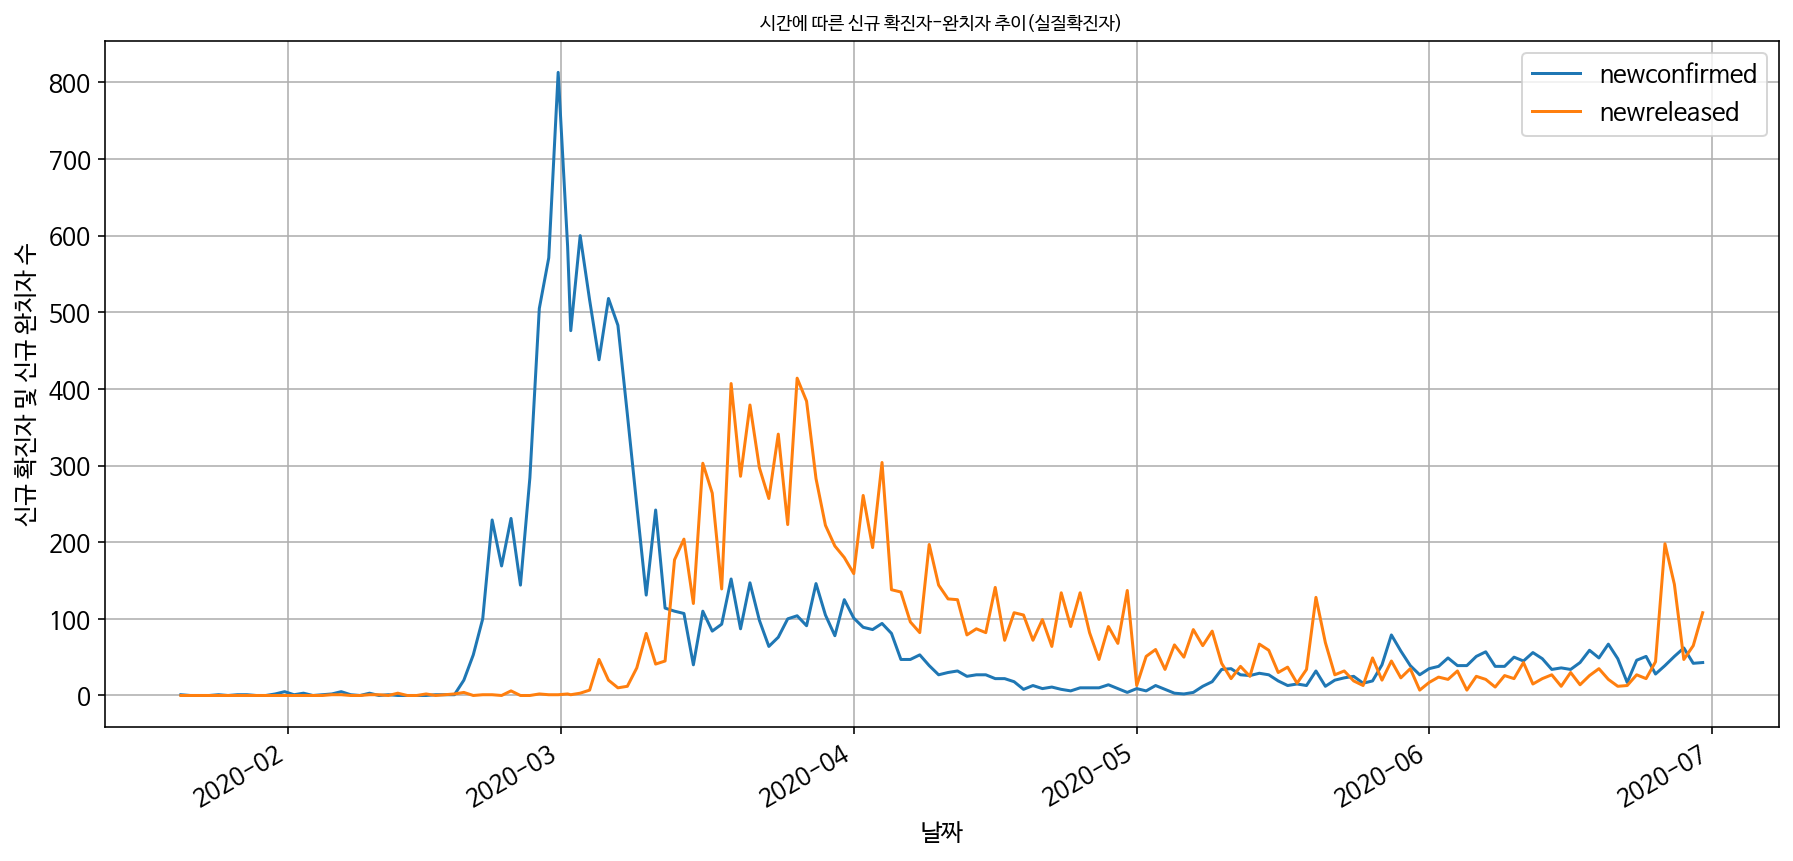

In [ ]:
covid_time1 = covid_time.filter(['date', 'newconfirmed','newreleased'])
covid_time1.set_index('date',inplace=True)

covid_time1['newconfirmed'].plot()
covid_time1['newreleased'].plot()
plt.grid()
plt.legend()
plt.title("시간에 따른 신규 확진자-완치자 추이(실질확진자)", fontproperties=font)
plt.xlabel("날짜")
plt.ylabel("신규 확진자 및 신규 완치자 수")

- 위 그래프는 일별 신규 확진자와 신규 완치자 추이를 나타내는 그래프이다. 신규 확진자 수가 신규 완치자 수를 훌쩍 넘는 4월 초중순 정도까지의 구간은 코로나 확진세가 잘 잡히지 않던 정황을 보여주고, 그 이후는 코로나 확진세가 좀 잠잠해졌음을 보여준다.



---



- 정부의 발빠른 정책으로 코로나가 7월까지는 코로나가 많이 완화되었음을 알 수 있다. 하지만 분석을 진행중인 8월 말~9월 초 시기에는 아쉽게도 일부 안일한 국민들 때문에 코로나가 다시 유행하고 있다.

- 그 중 가장 논란의 중심에 있는 사랑제일교회 광화문 시위의 문제점에 주목할 필요가 있다. 많은 사람들이 모여 시위를 하는 것은 전염병의 확산 측면에서 매우 위험하다. 집회 참가자 중 대다수는 집회 이후 귀가 시 감염의 위험을 안은 채로 대중교통을 이용하였을 것이다.

- 이로 미루어 볼 때, **대중교통을 통한 코로나 전파 위험을 최소화하는 것을 통해 코로나의 확산 위험을 줄이는데 일조**할 수 있을 것이다. 따라서 대중교통의 혼잡도를 사전에 확인하고 상대적으로 혼잡하지 않은 수단을 이용할 수 있도록 유도하는 것이 중요하다.

In [ ]:
Patient

Age=Patient['age'].value_counts()

AgeDF=pd.DataFrame(Age)



AgeDF_order = AgeDF.sort_index(ascending=True)
                               
AgeDF_order['age']

AgeDF = AgeDF.reset_index() 
AgeDF.columns = ['age','confirmed']
AgeDF['age']=AgeDF['age'].str[0:2]

AgeDF['age'][8] = 0
AgeDF['age'][10] = 100

AgeDF['age'] = pd.to_numeric(AgeDF['age'])
 
AgeDF

,age,confirmed
0,20,899
1,50,667
2,30,523
3,40,518
4,60,482
5,70,232
6,10,178
7,80,170
8,0,66
9,90,49


In [ ]:
AgeDF = AgeDF.sort_values(by = ['age'])
AgeDF=AgeDF.set_index('age')
AgeDF

,confirmed
age,
0,66
10,178
20,899
30,523
40,518
50,667
60,482
70,232
80,170


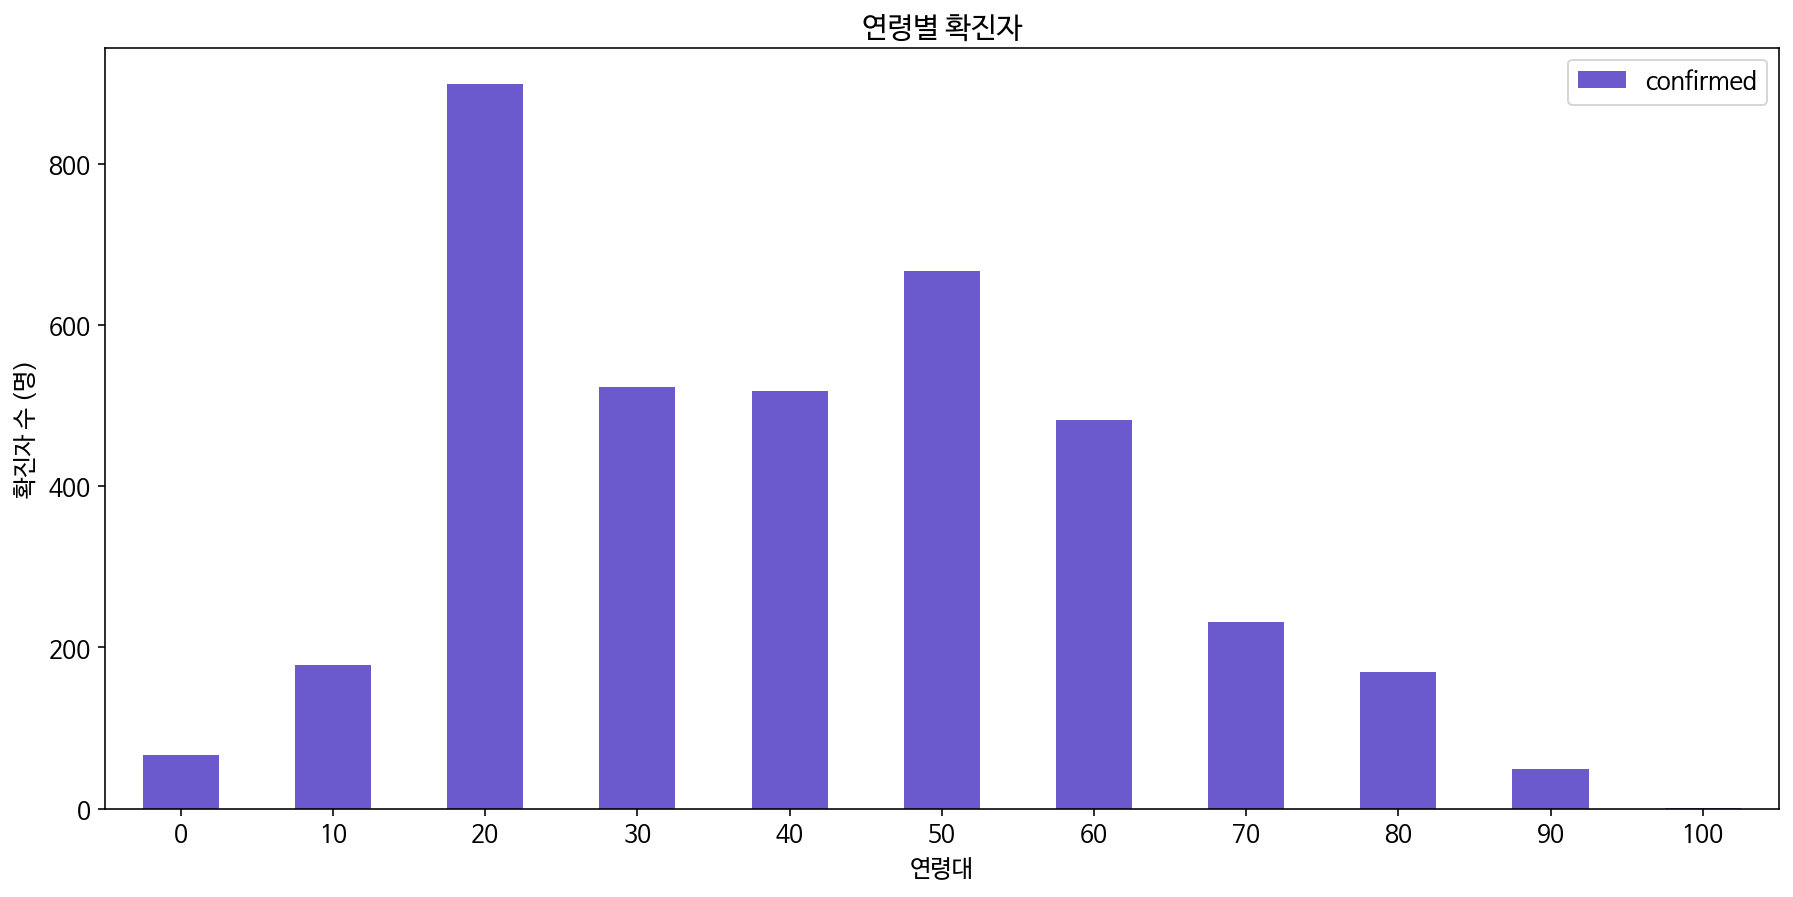

In [ ]:
AgeDF.plot(kind='bar',title="연령별 확진자", rot=0, color='slateblue')
plt.xlabel("연령대")
plt.ylabel("확진자 수 (명)")
plt.rcParams["figure.figsize"] = (10,4)
plt.rcParams['lines.linewidth'] = 2

- 경제활동인구가 많은 연령대에서 확진자 수가 높은 것을 볼 수 있다. 이는 곧 경제활동 인구가 활발한 연령대들이 상대적으로 위험에 노출되어 있는 것을 의미한다.

## 광역시별 데이터와 시군구별 데이터 split


---


- Region.csv 파일에서 제주도는 시군으로 나뉘어져있지 않기 때문에 City Dataframe에도 추가해주었다.
- Region.csv 파일의 오타를 발견해 직접 수정하였다.




In [ ]:
Metropolitan = [dict(Region.loc[index,:]) for index in Region.index if(Region.loc[index,'province'] == Region.loc[index,'city'])]
Metropolitan = pd.DataFrame(Metropolitan)
#마지막행 제거
Metropolitan = Metropolitan.iloc[:-1]
City = [dict(Region.loc[index,:]) for index in Region.index if(Region.loc[index,'province'] != Region.loc[index,'city'])]
City = pd.DataFrame(City)
#제주도 추가
City = City.append(Metropolitan.iloc[-1,:], ignore_index = True)
City.tail()

,code,province,city,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
222,61150,경상남도,하동,35.067224,127.751271,16,15,0,0.84,32.89,19.1,94
223,61160,경상남도,하만,35.272481,128.406540,16,20,0,1.19,23.74,14.7,94
224,61170,경상남도,함양,35.520541,127.725177,13,12,0,1.01,32.65,20.9,83
225,61180,경상남도,합천,35.566702,128.165870,17,15,0,0.71,38.44,24.7,96
226,70000,제주도,제주도,33.488936,126.500423,113,123,4,1.53,15.10,6.4,1245


##   - 자가격리자 수 분포 확인


---



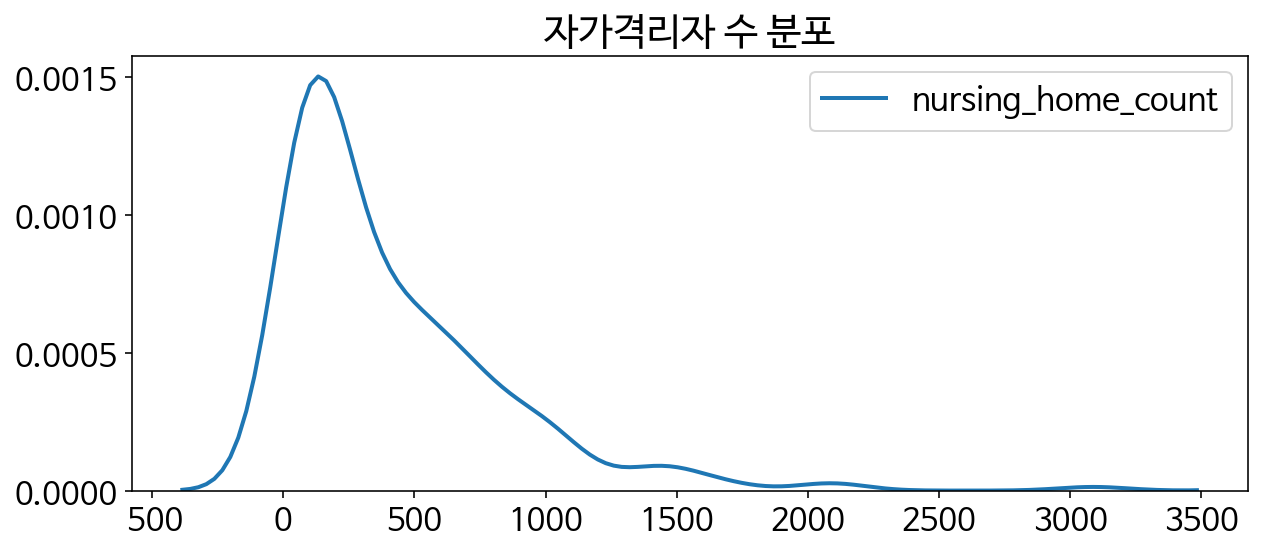

In [ ]:
plt.rcParams['font.size'] = 16

#그래프에 쓰일 폰트 및 사이즈 지정
#데이터 분포 확인하기(자가격리자)
import seaborn as sns
nursing = City['nursing_home_count']
sns.kdeplot(nursing)
plt.title("자가격리자 수 분포")
plt.show()

## 자가격리자를 정규분포로 만들기 위해 로그변환
---

- 이후 회귀모델 제작에 사용된다.

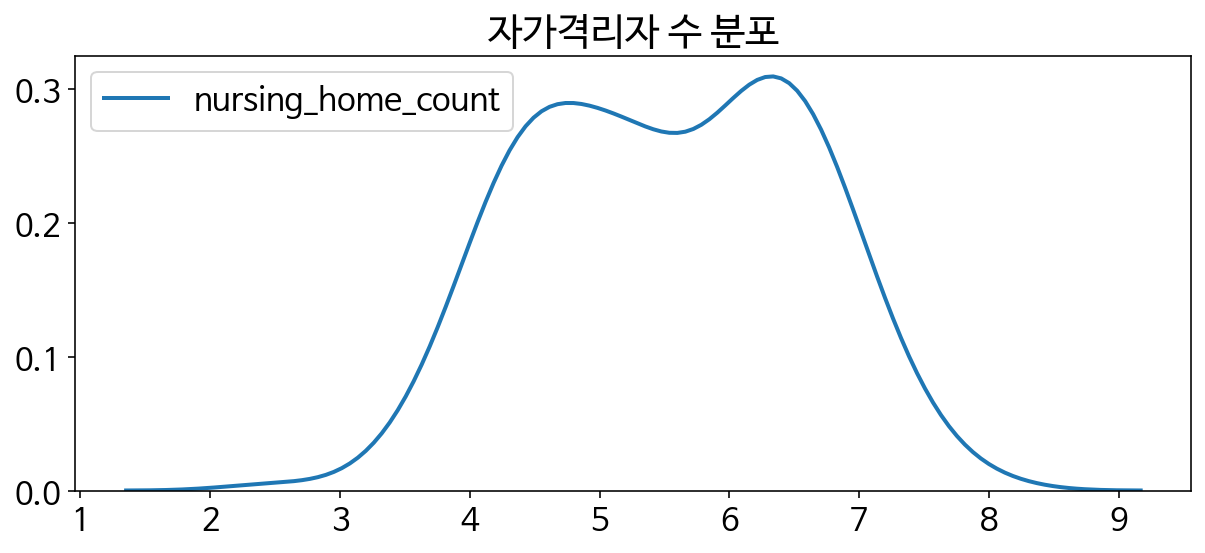

In [ ]:
nursing = np.log1p(nursing)
City['nursing_home_count'] = nursing 
sns.kdeplot(nursing)
plt.title("자가격리자 수 분포")
plt.show()

## 변수간 상관분석 실시


---





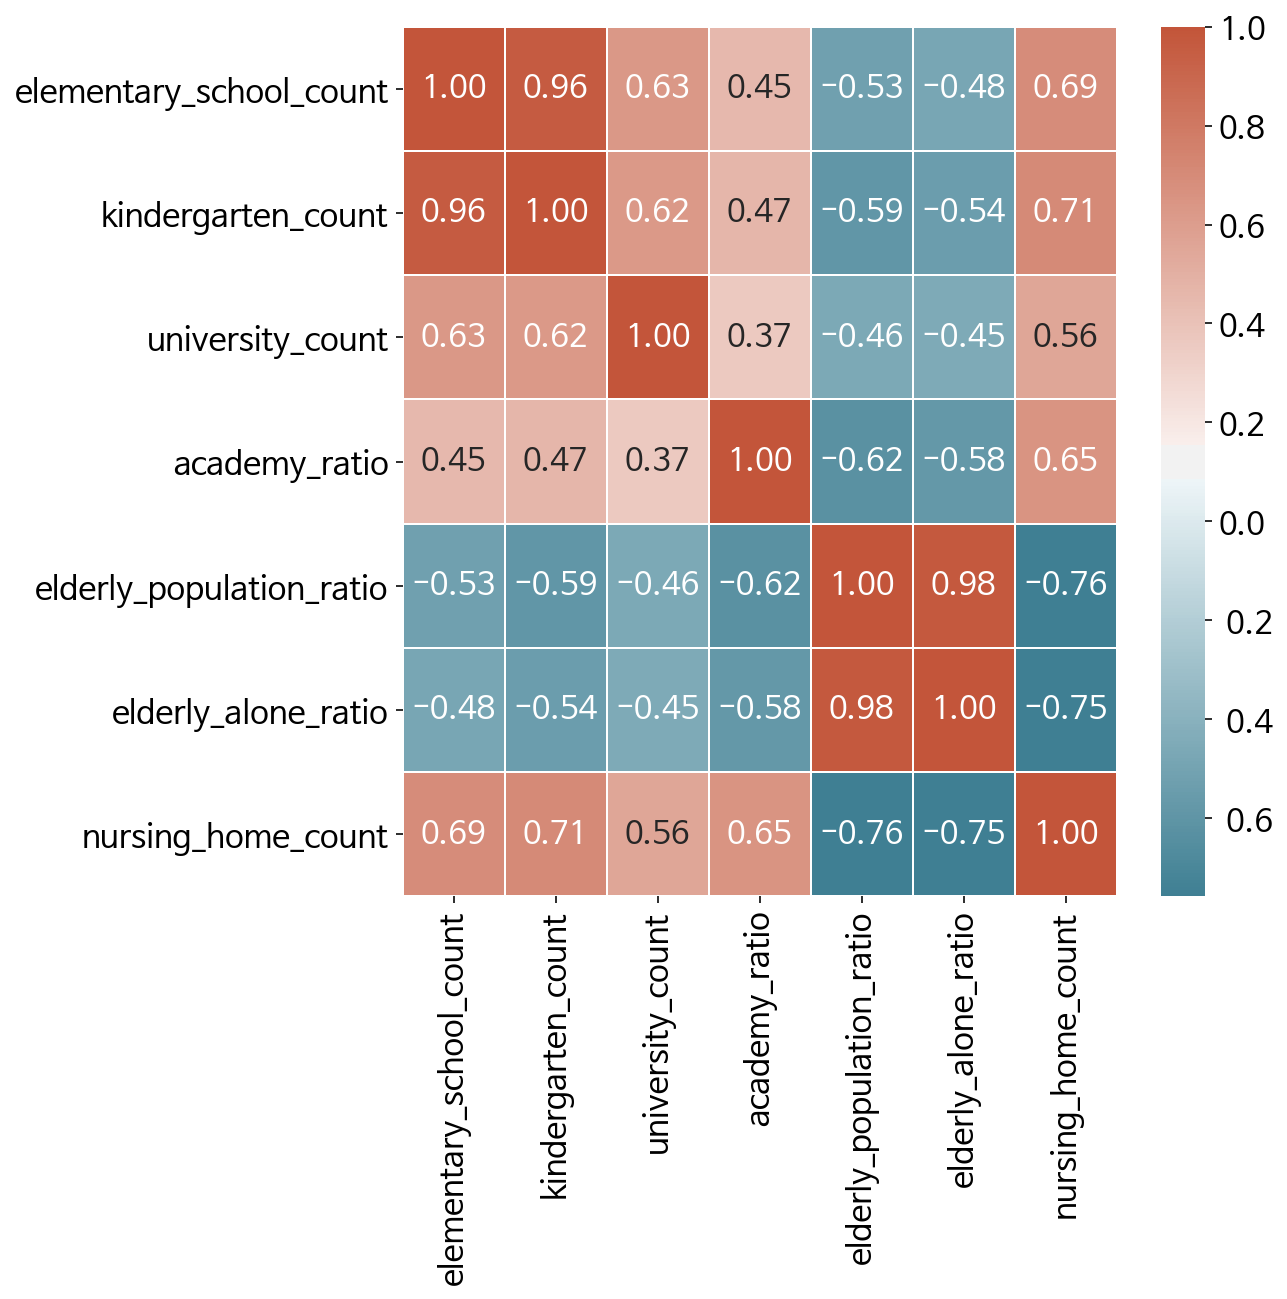

In [ ]:
#위도,경도,코드 column 삭제
City_cor = City.drop(['code'	,'province'	,'city',	'latitude'	,'longitude'],axis = 1)
plt.figure(figsize=(8,8))
sns.heatmap(data = City_cor.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap=sns.diverging_palette(220,20,as_cmap=True))

## 광역시별로 자가격리자 시각화

---

-   원의 크기가 클 수록 자가격리자 수가 많음을 의미


In [ ]:
#지도 초기화
Covid_map = folium.Map(location=[36, 127], tiles="OpenStreetMap", zoom_start=7)
for index in Metropolitan.index :
  lat = Metropolitan.loc[index,'latitude']
  long = Metropolitan.loc[index,'longitude']
  folium.CircleMarker([lat,long],
                     radius = Metropolitan.loc[index,'nursing_home_count']/700,
                     popup = Metropolitan.loc[index,'province'],
                     color = 'red',
                     fill = True).add_to(Covid_map)
Covid_map

##  시군구별로 자가격리자 데이터 시각화


---







In [ ]:
Covid_map2 = folium.Map(location=[36, 127], tiles="OpenStreetMap", zoom_start=7)
for index in City.index :
  lat = City.loc[index,'latitude']
  long = City.loc[index,'longitude']
  folium.CircleMarker([lat,long],
                     radius = City.loc[index,'nursing_home_count']/9,
                     popup = City.loc[index,'province'],
                     color = 'blue',
                     fill = True).add_to(Covid_map2)
Covid_map2

### shape file 불러오기 및 좌표계 변환


---


*   시군구별로 자가격리자의 수를 나타내기 위해 시군구별 구역이 나눠져있는 외부데이터 **shapefile**을 이용하였다.



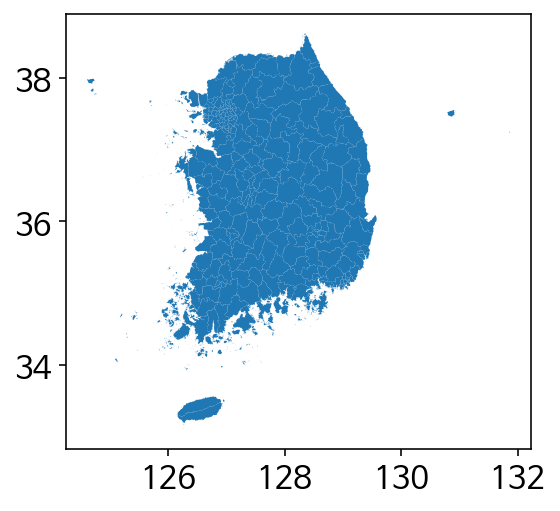

In [ ]:
gdf = gpd.read_file("SIG.shp",encoding = 'EUC-KR')
gdf = gdf.to_crs({'init' : 'epsg:4326'})
gdf.plot()

### 외부 데이터와 내부 데이터 Merge하기

---

 -  데이터를 병합하기 위해서는 기준이 되는 열의 규칙이 같아야 하므로 엑셀파일로 직접 추가적인 작업(Column 추가, 지역 이름 동일 규칙 적용)을 실시하였다.
 - Merge의 기준이 되는 열은 'province'와 'city'로 설정하였다.





In [ ]:
gdf1 = pd.read_excel('Revised_gps_data.xlsx')
gdf1.drop(['Unnamed: 0'],axis=1,inplace=True)
gdf.SIG_CD = gdf1['province']
gdf.SIG_KOR_NM = gdf1['city']
gdf = gdf.drop(['SIG_ENG_NM'], axis = 1)
gdf.columns = ['province','city','geometry']
City = pd.read_excel("Revised_City.xlsx")
Merge_data = pd.merge(left=gdf, right=City, how='left', on=['province','city'], sort=False)
Merge_data.drop(['Column1','code'],axis = 1, inplace = True)
Merge_data.head(1)

,province,city,geometry,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
0,서울,종로구,"POLYGON ((127.00864 37.58047, 127.00871 37.580...",37.572999,126.979189,13,17,3,1.71,18.27,6.8,668


  ### 시군구별 자가격리자 수 데이터 시각화
---

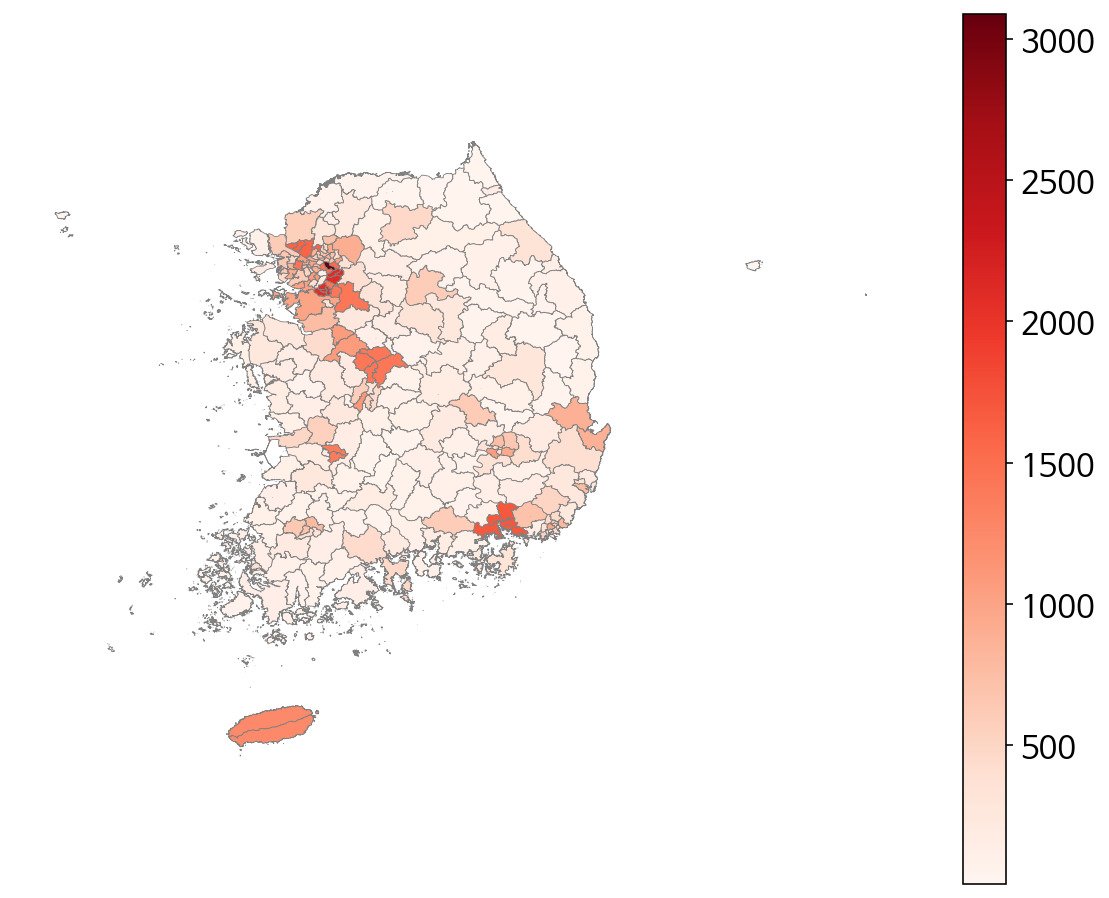

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
Merge_data.plot(ax=ax, column="nursing_home_count", cmap="Reds",edgecolor="grey", linewidth=0.4, legend=True)
ax.axis("off")
plt.axis('equal')
plt.show()

- 위 지도를 보면 수도권에 자가격리자가 집중되어 있는 것을 확인할 수 있다.  이 보고서에서는 전 국민의 약 5분의 1이 거주하고 있는 서울을 중점적으로 분석하고자 한다. 최근 사랑제일교회의 광화문 시위 여파로 코로나가 순식간에 확산된 것으로 봤을 때 **대한민국 코로나 안전의 핵심은 인구 밀도가 가장 높은 서울**이기 때문이다.

# 2. 교통 데이터 전처리


## 2.1 TS교통카드 정류장 이용량(DM_STTN_USEV_SMY) 데이터 전처리  
- 라이브러리 호출
   - TS교통카드 데이터는 dat파일임에도 용량이 매우 커서 대용량 데이터를 다루기에 더 편한 R로 전처리를 진행하였다. 'gsplit'이라는 프로그램을 통해 약 40기가에 달하는 데이터를 분할할 수 있었고 R로 불러와 전처리를 하였다.     

In [ ]:
# install.packages('data.table')
# install.packages('bit64') 
# install.packages('dplyr')
# library(data.table)
# library(bit64)
# library(dplyr)

## 2.2 TS교통카드 정류장 이용량(DM_STTN_USEV_SMY) 데이터 전처리      

In [ ]:
# DM1 <- fread('disk19.txt', sep='|', header = F,encoding = 'UTF-8')

In [ ]:
# DM1<-as.data.frame(DM1)

# colnames(DM1) = c('YYYY',	'YYYYMM',	'OPRAT_DATE'	,'WEEK_GB','TZON','USER_TYPE_CD','TCBO_ID','EXCCLC_AREA_CD','TFCMN_GB_CD'	,'STTN_ID',	'SD_CD',	'SGG_CD'	,'USE_AREA_CD',	'GIN_STF',	'GFF_STF')

# idx <- DM1$OPRAT_DATE %in% c('20200518','20200519','20200520','20200521','20200522','20200523','20200524')

# DM1 <- DM1[idx,] ; idx <- DM1$SD_CD =='11' ; DM1 <- DM1[idx,]

# idx <- DM1[,9] != 'B' ; DM1 <- DM1[idx==F,]

# DM1 <- DM1[,c(2:5,10:15)]

# DM1$date = as.Date(as.character(DM1$OPRAT_DATE), "%Y%m%d")

# DM1$STTN_ID <- as.integer64(DM1$STTN_ID)

In [ ]:

# GIN_CNT <-aggregate(DM1$GIN_STF,
#                   by = list(DM1$TZON, DM1$OPRAT_DATE, DM1$SGG_CD, DM1$STTN_ID),
#                    sum)

# GFF_STF <-aggregate(DM1$GFF_STF,
#                    by = list(DM1$TZON, DM1$OPRAT_DATE, DM1$SGG_CD, DM1$STTN_ID),
#                   sum)

# GFF_STF[,6] <- GIN_CNT[,5]

# colnames(GFF_STF) <-  c('TZON','DATE','SGG_CD','STTN_ID','GIN_STF','GFF_STF')

# colnames(dd_area) <- c('OPRAT_DATE',	'TCBO_ID',	'EXCCLC_AREA_CD',	'TFCMN_GB_CD',	'STTN_ID'	,'STTN_NMA',	'STTN_ARSNO'	,'SD_CD',	'SGG_CD'	,'USE_AREA_CD'	,'ROUTE_CNT') 

# GFF_STF <- na.omit(GFF_STF)

In [ ]:
# head(GFF_STF)

## 2.3 TS교통카드 정류장(DM_STTN_T.dat) 데이터 전처리

In [ ]:

# 정류장 이름이 있기 때문에 정류장별 승하차인원이랑 통합예정
# dd_area <- fread("DM_STTN_T.dat", sep='|', header = F, encoding = "UTF-8")

# 필요한 열 추출
# idx <- dd_area$V8 =='11' ; dd_area <- dd_area[idx,]

# idx <- dd_area$V1 %in% c('20200518','20200519','20200520','20200521','20200522','20200523','20200524')

# dd_area <- dd_area[idx,] ; dd_area<-as.data.frame(dd_area)


In [ ]:
# head(dd_area)

In [ ]:
# 
# # 라이브러리 호출
# # library(data.table) ; library(bit64) ;library(dplyr)
 
# # 데이터 불러오기
# dd_area
# dd_area<-as.data.frame(dd_area) 
# DM1 <- fread('disk19.txt', sep='|', header = F,encoding = 'UTF-8')
# D1<-DM1

# #데이터 형식 변환
# DM1<-as.data.frame(DM1)

# #열 이름 설정
# colnames(DM1) = c('YYYY',	'YYYYMM',	'OPRAT_DATE','WEEK_GB','TZON','USER_TYPE_CD','TCBO_ID','EXCCLC_AREA_CD',
#                   'TFCMN_GB_CD'	,'STTN_ID',	'SD_CD',	'SGG_CD'	,'USE_AREA_CD',	'GIN_STF',	'GFF_STF')

# #idx로 뽑아내어 해당 일에 당하는 데이터들을 추출
# idx <- DM1$OPRAT_DATE %in% c('20200518','20200519','20200520','20200521','20200522','20200523','20200524') ; DM1 <- DM1[idx,]

# #필요한 열만 추출
# idx <- DM1$SD_CD =='11' ; DM1 <- DM1[idx,] ; idx <- DM1[,9] != 'B' ; DM1 <- DM1[idx==F,]

# #필요한 열만 추출, 날짜 형식으로 변경
# DM1 <- DM1[,c(2:5,10:15)] ; DM1$date = as.Date(as.character(DM1$OPRAT_DATE), "%Y%m%d")

# #정수 형식으로 변경
# DM1$STTN_ID <- as.integer64(DM1$STTN_ID)

# #GIN_STF는 승차인원이다. 일별 시간별 정류장별로 승차인원을 통합
# GIN_CNT <-aggregate(DM1$GIN_STF,
#                     by = list(DM1$TZON, DM1$OPRAT_DATE, DM1$SGG_CD, DM1$STTN_ID),
#                     sum)

# #GIN_STF는 승하차인원이다. 일별 시간별 정류장별로 승하차인원을 통합
# GFF_STF <-aggregate(DM1$GFF_STF,
#                     by = list(DM1$TZON, DM1$OPRAT_DATE, DM1$SGG_CD, DM1$STTN_ID),
#                     sum)

# #하나의 데이터프레임으로 제작
# GFF_STF[,6] <- GIN_CNT[,5]

# #열 이름 설정
# colnames(GFF_STF) <-  c('TZON','DATE','SGG_CD','STTN_ID','GIN_STF','GFF_STF')
# colnames(dd_area) <- c('OPRAT_DATE',	'TCBO_ID',	'EXCCLC_AREA_CD',	'TFCMN_GB_CD',	'STTN_ID'	,
#                        'STTN_NMA',	'STTN_ARSNO'	,'SD_CD',	'SGG_CD'	,'USE_AREA_CD'	,'ROUTE_CNT') 

# #NA값 제거
# GFF_STF <- na.omit(GFF_STF)

# #정류장 이름을 얻기 위해 정류장 ID를 key로 양 테이블을 조인
# BUS <- full_join(GFF_STF , dd_area, by = 'STTN_ID')

# #버스에 관한 정보가 필요하므로 제외한 나머지는 삭제
# BUS5 <- BUS[BUS$TFCMN_GB_CD =='B',] ; BUS1<-na.omit(BUS) ; BUS2 <- BUS1[,c(1:6,11)]

# #위와 마찬가지로 버스 승하차인원 통합
# BUS3 <-aggregate(BUS2$GIN_STF,
#                     by = list(BUS2$TZON, BUS2$DATE, BUS2$SGG_CD.x, BUS2$STTN_ID, BUS2$STTN_NMA),
#                     sum)
# BUS4 <-aggregate(BUS2$GFF_STF,
#                  by = list(BUS2$TZON, BUS2$DATE, BUS2$SGG_CD.x, BUS2$STTN_ID, BUS2$STTN_NMA),
#                  sum)
# BUS3[,7] <- BUS4[,6]
# #열이름 설정

# colnames(BUS3) <- c('TZON', 'DATE', 'SGG_CD', 'STTN_ID','STTN_NMA','GIN_STF','GFF_STF')
# #csv파일 제작
# write.csv(BUS3, "BUS3_1.csv",row.names = F)


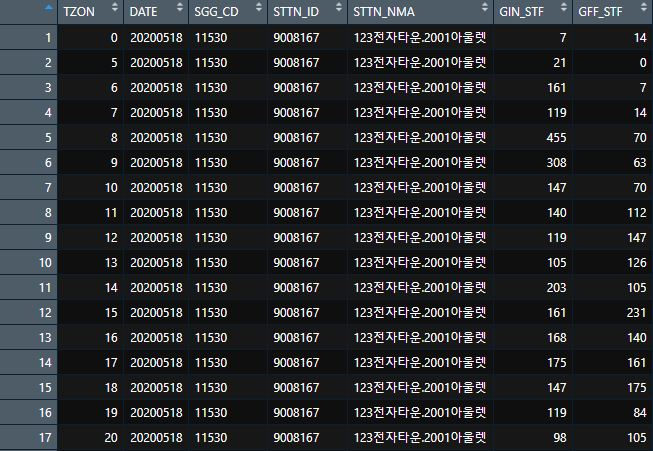

# 3.대중교통 안전경로 추천 프로세스 제작
## 3.1 배경


- 코로나 장기화 시대에서 국민들로 하여금 이동을 제한 및 통제하기는 사실상 어려운 상황이다.
- 따라서 대규모 이동을 통제할 수 없다면 대중교통 경로에 있어서 소요 시간보다는 **안전에 초점을 둔 경로**를 추천하여 **이동 인구의 분배**를 꾀하는 것을 제안하고자 한다.



---


## 3.2구현 방안
#### 1. 데이터 활용
1. 지하철 역별 이용 인원 데이터 (출처 : 서울열린데이터광장)
2. 버스 정류장별 이용 인원 데이터 (출처 : 한국교통안전공단)
 - 교통카드 데이터의 정류장별 이용량 테이블을 활용
3. 지하철 역별 위도 경도 좌표 데이터
 - 1번 데이터의 지하철역 목록을 Google SpreadSheet의 확장프로그램인 GeoCode By Awesome Table 기능을 이용하여 매핑
4. 버스 정류장 위도 경도 좌표 데이터 (출처 : 서울열린데이터광장)
 - 버스 정류장별 위치 정보 데이터 활용 
5. 확진자 방문장소 데이터
 - 코로나있다 사이트 활용하여 직접 수집
6. 경로 추천을 위한 데이터 (출처 : ODsay API)
 - 출발지와 도착지 입력에 따른 길찾기 API 활용

#### 2. 안전점수 계산을 위한 지표 선정
1. 경로 상의 출발지, 환승지, 도착지에 해당하는 지하철역 또는 버스 정류장의 혼잡도
2. 경로 상의 환승지에 해당하는 지하철역 또는 버스 정류장의 반경 3km 내 확진자 방문장소의 수

- 여러 함수를 구축하여 위 지표를 도출하고 이에 따른 안전점수 기반 경로를 추천한다.


### 필요 데이터 불러오기

In [ ]:
# 지하철역 이용량 데이터
Subway = pd.read_csv('Subway_Popularity_July.csv', encoding='cp949')

# 버스정류장 이용량 데이터
Bus = pd.read_csv('BUS3_2.csv', encoding='cp949')

# 지하철역 위도 경도 데이터
SubwayLongLat = pd.read_csv('SubwayLocation.csv', encoding='utf-8')

# 버스정류장 위도 경도 데이터
BusLongLat = pd.read_csv('BusLocation.csv', encoding='cp949')

# 확진자 방문장소 데이터
Visitor = pd.read_csv('Place_Visitors.csv', encoding='utf-8')

### 데이터 전처리
#### Subway 데이터
- Subway 데이터에서 사용하고자 하는 column은 요일, 역명, 그리고 시간 변수들이다.
- 필요없는 column들을 삭제하고 시간변수 column명들을 쓰기 용이하게 변환하였다.
- 요일과 역명에 따른 시간대별 합계 정보가 필요하기 때문에 요일과 역명을 기준으로 그룹화하여 합계를 낸 데이터를 Subway_DayOfWeek 변수에 저장하였다.

In [ ]:
ColumnList = []
NameList = []


# column명 전처리
Subway.columns = Subway.columns.str.replace(" ","")
Subway.columns.values[:11] = Subway.columns[:11].str.replace("0","")
for Column in Subway.columns:
  ColumnList.append(Column.split('~')[0])
Subway.columns = ColumnList

# column명 변경 및 필요없는 column 삭제
Subway['역명'].str.split('(')[0]
Subway = Subway.rename({'6시이전':'5','24시이후':'24'}, axis='columns')
Subway = Subway.drop(['구분','할인','호선','역번호','합계'], axis='columns')

# 필요한 열 기준으로 그룹화하여 합산
Subway = Subway.groupby(['날짜','역명']).sum()
Subway = Subway.reset_index()

# 역명 뒤에 ()붙으면 그 앞까지만 저장
for Station in Subway['역명']:
  NameList.append(Station.split('(')[0])

Subway['역명'] = NameList

# 날짜형식 변환 및 요일 column 추가
Subway['날짜'] = pd.to_datetime(Subway['날짜'])
Subway.insert(1,'요일',Subway['날짜'].dt.dayofweek)

# 필요한 열 기준으로 그룹화하여 합산
Subway_DayOfWeek = Subway.groupby(['요일','역명']).sum()
Subway_DayOfWeek = Subway_DayOfWeek.reset_index()

Subway_DayOfWeek.head()

,요일,역명,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0,가락시장,1162,3685,9240,17534,9281,6268,5895,5886,5903,6178,6949,7644,9376,16445,8984,5753,5327,4160,1882,468
1,0,가산디지털단지,1836,5137,25949,75722,41787,11842,7818,7615,8411,8598,9652,12138,31715,64671,29128,14908,11776,6756,2477,150
2,0,강남,3139,12408,34736,71851,69466,30560,28047,27893,35029,32339,35061,37461,56558,91328,54911,33978,36231,33969,10873,3
3,0,강남구청,471,2318,6648,20377,15134,5548,3878,3587,4181,4232,4883,5074,8061,17718,10109,5380,5304,4030,1634,78
4,0,강동,1926,5555,16441,22907,10286,5969,5446,5428,5706,5522,6161,7292,11617,18008,11437,6502,5403,4643,2547,187


#### 지하철 역별 위도 경도 좌표 데이터
- Subway_DayOfWeek 데이터의 역명 형식에 맞게 역명을 변환해주고 column명을 변환해주었다.

In [ ]:
#불필요한 열 제거
SubwayLongLat = SubwayLongLat.drop(['Unnamed: 3','place'], axis='columns')

# Subway_DayOfWeek 데이터프레임에 맞게 문자열 처리, column 명 변환
SubwayLongLat['address'] = SubwayLongLat['address'].str[:-1]
SubwayLongLat['address'][SubwayLongLat['address'] == '서울'] = '서울역'
SubwayLongLat = SubwayLongLat.rename({'address' : '역명'}, axis='columns')
SubwayLongLat.head()

,역명,Latitude,Longitude
0,가락시장,37.492857,127.114868
1,가산디지털단지,37.480890,126.882574
2,강남,37.517236,127.047325
3,강남구청,37.517351,127.047438
4,강동,37.530125,127.123762


#### 버스 정류장별 이용 인원 데이터
- 하차인원보다는 그 시간대에 정류장에서 기다리고 있었을 승차인원을 기준으로 하는 것이 혼잡도를 추정하는데 더 유리하다고 판단했다.
- 따라서 버스 정류장 데이터에서 이용하고자 하는 것은 시간, 요일, 역명에 따른 승차인원의 합계 정보이다.
- 시간 요일 역명을 기준으로 그룹화하여 합계를 낸 데이터를 Bus_DayOfWeek 변수에 저장했다.

In [ ]:
# 날짜 형식으로 변환
Bus['DATE'] = Bus['DATE'].astype(str)
Bus['DATE'] = Bus['DATE'].str[:4] + '-' + Bus['DATE'].str[4:6] + '-' + Bus['DATE'].str[-2:]
Bus['DATE'] = pd.to_datetime(Bus['DATE'])

# 필요없는 column 제거 및 요일 column 추가
Bus.columns = ['시간', '날짜', '시군구코드','역번호','역명','승차인원','하차인원']
Bus.insert(1,'요일',Bus['날짜'].dt.dayofweek)
Bus = Bus.drop(['날짜','시군구코드','역번호','하차인원'], axis='columns')

# 필요한 열 기준으로 그룹화하여 합산
Bus_DayOfWeek = Bus.groupby(['시간','요일','역명']).sum()
Bus_DayOfWeek = Bus_DayOfWeek.reset_index()

Bus_DayOfWeek.head()

,시간,요일,역명,승차인원
0,0,0,123전자타운.2001아울렛,7
1,0,0,12번지건영아파트,28
2,0,0,14단지상가,21
3,0,0,1호선구일역,14
4,0,0,201동.동신교회,7


#### 버스 정류장별 위도 경도 좌표 데이터
- 필요한 column만 남기고 이용하기 용이하게 column 이름을 변환하였다.

In [ ]:
# 필요없는 column 제거 및 column명 변환
BusLongLat = BusLongLat.drop(['표준ID','ARS-ID','비고'], axis='columns')
BusLongLat = BusLongLat.rename({'정류장명':'역명', 'X좌표':'Longitude', 'Y좌표':'Latitude'}, axis='columns')
BusLongLat.head()

,역명,Longitude,Latitude
0,종로2가사거리,126.987750,37.569765
1,창경궁.서울대학교병원,126.996566,37.579183
2,명륜3가.성대입구,126.998340,37.582671
3,종로2가.삼일교,126.987613,37.568579
4,혜화동로터리.여운형활동터,127.001744,37.586243


### 함수 구축

#### 1. TimeRoute 함수
* API를 통해 받아오게 될 추천 경로 Json 파일을 참조하기 좋게, 그리고 보기 쉽게 정리하고자 하는 함수이다.
* Input값으로 받은 Json 파일에서 경로 유형, 총 소요시간, 교통수단 유형, 호선 및 노선, 역 이름 등의 정보를 추출하여 하나의 리스트로 결과값을 반환한다.

In [ ]:
def TimeRoute(JsonFile):
  RouteList = []
  
  # 경로마다 PathType, TotalTime 저장
  for PathType in JsonFile['result']['path']:
    Route = [{'PathType' : PathType['pathType'], 'TotalTime' : PathType['info']['totalTime']}]

    # trafficType 확인 후 해당 데이터셋에서 조회하여 필요한 값들 저장
    for Path in PathType['subPath'][1:-1]:
      if Path['trafficType'] == 1:
        Route.append({'TrafficType' : Path['trafficType'], 'StationID' : Path['startID'], 'Lane' : Path['lane'][0]['name'], 'StationName' : Path['startName']})

      elif Path['trafficType'] == 2:
        Route.append({'TrafficType' : Path['trafficType'], 'StationID' : Path['startID'], 'Lane' : Path['lane'][0]['busNo'], 'StationName' : Path['startName']})


    Route.append({'StationID' : Path['endID'], 'StationName' : Path['endName']})
    RouteList.append(Route)


  return(RouteList)

#### 2. NumOfPeople 함수
- 1번 함수를 통해 정리된 자료를 input 값으로 받아 각 정류장 및 지하철 역이 현재 요일 및 시간대에 어느 정도의 사람들이 이용했는지를 정리하고자 하는 함수이다.
- 각 루트의 경로 유형과 교통수단 유형을 참조하여 버스인지, 지하철인지를 파악 후 해당 데이터프레임에서 이용인원을 조회하여 리스트에 추가하고, 이를 결과값으로 반환한다.

In [ ]:
def NumOfPeople(TimeRouteFile):
  DayOfWeek = dt.datetime.now().weekday()
  RouteTime = dt.datetime.now().hour
  RouteSumList = []
  TypeList = []

  # PathType과 TrafficType을 확인하여 적절한 데이터셋으로부터 유동인구를 저장
  for Route in TimeRouteFile:
    RouteSum = []
    Type = []
    if Route[0]['PathType'] == 1:
      for Station in Route[1:]:
        RouteSum.append(sum(Subway_DayOfWeek['{}'.format(RouteTime)][Subway_DayOfWeek['요일'] == DayOfWeek][Subway_DayOfWeek['역명'] == Station['StationName']]))
        Type.append(1)

    elif Route[0]['PathType'] == 2:
      for Station in Route[1:]:
        RouteSum.append(sum(Bus_DayOfWeek['승차인원'][Bus_DayOfWeek['시간']==RouteTime][Bus_DayOfWeek['요일']==DayOfWeek][Bus_DayOfWeek['역명']==Station['StationName']]))
        Type.append(2)
    
    else:
      for Station in Route[1:-1]:
        if Station['TrafficType'] == 1:
          RouteSum.append(sum(Subway_DayOfWeek['{}'.format(RouteTime)][Subway_DayOfWeek['요일'] == DayOfWeek][Subway_DayOfWeek['역명'] == Station['StationName']]))
          Type.append(1)
        else:
          RouteSum.append(sum(Bus_DayOfWeek['승차인원'][Bus_DayOfWeek['시간']==RouteTime][Bus_DayOfWeek['요일']==DayOfWeek][Bus_DayOfWeek['역명'] == Station['StationName']]))
          Type.append(2)
      if Station['TrafficType'] == 1:
        RouteSum.append(sum(Subway_DayOfWeek['{}'.format(RouteTime)][Subway_DayOfWeek['요일'] == DayOfWeek][Subway_DayOfWeek['역명'] == str(Route[-1]['StationName'])]))
        Type.append(1)
      else:
        RouteSum.append(sum(Bus_DayOfWeek['승차인원'][Bus_DayOfWeek['시간']==RouteTime][Bus_DayOfWeek['요일']==DayOfWeek][Bus_DayOfWeek['역명']==Route[-1]['StationName']]))
        Type.append(2)
      
    TypeList.append(Type)
    RouteSumList.append(RouteSum)



  return(RouteSumList,TypeList)

#### 3. RouteIndex 함수
* 길찾기 API를 통해 많은 수의 경로가 추천되는데, 총 소요시간 기준 상위 5개 정도의 경로가 아니면 소요시간이 매우 길어 의미가 없는 경로라고 판단하였다.
* 또한, 경유하는 정류장들은 같지만 버스 번호만 달라 정류장별 혼잡도는 똑같은 경로들이 존재한다.
* 이 함수는 경유하는 정류장과 역들이 완전히 일치하는 경로들은 하나만 남기면서 상위 5개 경로들의 정보와 인덱스를 남기는 함수이다.

In [ ]:
def RouteIndex(NumOfPeopleFile):
  NewNumList = []
  IndexList = []
  NewIndexList = []

  # 중복 경로 제거하는 반복문 생성
  for idx, NumList in enumerate(NumOfPeopleFile[0]):
    if NumList not in NewNumList:
      NewNumList.append(NumList)
      IndexList.append(idx)
      NewIndexList.append(NumOfPeopleFile[1][idx])

  NewNumList = NewNumList[:5]
  IndexList = IndexList[:5]
  NewIndexList = NewIndexList[:5]

  return(NewNumList, IndexList, NewIndexList)

#### 4. CongestionLevel 함수

- 혼잡도 점수 계산 프로세스 <지표 1>
  1.   지하철 역과 버스 정류장의 유동인구 수준의 차이가 존재하므로 지하철 역의 기초 level 단위를 1000으로, 버스 정류장의 기초 level 단위를 115로 지정한다.
  2.   기초 level 단위가 임의로 정해진 만큼, 버스 level 척도와 지하철 level 척도의 큰 차이가 발생할 수 있다. 이를 방지하기 위해서는 버스는 최대로 부여될 수 있는 level이 어느 정도이고 지하철은 어느정도인지 알아내어 그 정도가 비슷해질 수 있도록 Scaling하는 작업이 필요하다.
  3.   먼저, 해당 요일, 시간대의 지하철역과 버스 정류장 유동인구 최대값을 기초 level로 나누어 최대로 지정될 수 있는 level이 어느 정도인지 계산한다.
  4.   만약 버스 최대 level이 50이고, 지하철 최대 level이 100이라면, (버스 최대 level/지하철 최대 level), 즉, 0.5를 지하철 최종 지표에 곱하여 양 지표 척도를 비슷하게 만들 수 있다. 따라서, 각각의 최대 level 수준을 서로 나누어 최종 점수 Scaling에 이용할 비율 지표 'Ratio'를 구한다.
  5.   3번 함수에서 구한 5개의 경로 내 역들의 유동 인구 수를 기초 level 단위로 나누어 유동 인구 level을 구하고, 지하철역 level에 미리 구한 Ratio를 곱하여 버스 level 척도와 비슷한 수준으로 스케일링을 해준다.
  6.   구해진 점수들을 각 경로에 대한 상대 점수로 환산한다.



In [ ]:
def CongestionLevel(RouteIndexFile):
  DayOfWeek = dt.datetime.now().weekday()
  RouteTime = dt.datetime.now().hour

  # 기초 level 단위 지정
  PopSubLevel = 1000
  PopBusLevel = 115

  # 최대 가능 level 계산
  MaxPopSub = np.max(Subway_DayOfWeek['{}'.format(RouteTime)][Subway_DayOfWeek['요일'] == DayOfWeek])//PopSubLevel + 1
  MaxPopBus = np.max(Bus['승차인원'][Bus['시간'] == RouteTime][Bus['요일'] == DayOfWeek])//PopBusLevel + 1
  
  # Scaling Ratio 계산
  Ratio = MaxPopBus / MaxPopSub

  LevelList1 = []
  LevelList = []

  # 혼잡도 점수 계산
  for i in range(len(RouteIndexFile[1])):
    Level = []
    for j in range(len(RouteIndexFile[2][i])):
      if RouteIndexFile[2][i][j] == 1:
        Level.append((RouteIndexFile[0][i][j] // PopSubLevel + 1) * Ratio)
      
      else:
        Level.append(RouteIndexFile[0][i][j] // MaxPopBus + 1)
    
    LevelList1.append(round(sum(Level), 4))

  for Levels in LevelList1:
    LevelList.append(round(Levels/sum(LevelList1),4))
  
  return(LevelList)

#### 5. TransferStation 함수
- 두 번째 지표인 반경 3km 내 확진자 방문 장소 수를 계산할 때, 출발지와 도착지는 그 위치가 큰 차이가 있기 힘들기 때문에, 환승 지역만을 기준으로 계산해야 한다.
- 따라서, 이 함수를 통해 경로들의 환승역만 모아 결과값으로 반환한다.

In [ ]:
def TransferStation(TimeRouteFile):
  Idx = RouteIndex(NumOfPeople(TimeRouteFile))[1]
  TransferList = []

  # 환승지 데이터만 빼서 저장
  for idx in Idx:
    TransferStation = []
    for Station in TimeRouteFile[idx][1:-1]:
      TransferStation.append({'TrafficType' : Station['TrafficType'], 'StationName' : Station['StationName']})
    TransferList.append(TransferStation)
  
  return(TransferList)

#### 6. LongLat 함수
* 확진자 방문장소가 반경 내에 있는지 확인하기 위해서는 환승 지역의 위치 좌표도 필요하다.
* 따라서 이 함수에서는 5번 함수에서 도출한 경로 내 환승 지역들의 위도 경도 좌표를 데이터프레임으로부터 찾아 딕셔너리 형태로 리스트에 저장하여 반환한다.

In [ ]:
def LongLat(TransferStationFile):
  LongLatList = []
  for Stations in TransferStationFile:
    LongLat = []

    # TrafficType 확인 후 적절한 데이터 셋에서 위도와 경도 좌표 조회하여 저장
    for Station in Stations:
      if Station['TrafficType'] == 1:
        LongLat.append({'Latitude' : np.max(SubwayLongLat['Latitude'][SubwayLongLat['역명']==Station['StationName']].astype('float')), 'Longitude' : np.max(SubwayLongLat['Longitude'][SubwayLongLat['역명']==Station['StationName']].astype('float'))})
      else:
        LongLat.append({'Latitude' : np.max(BusLongLat['Latitude'][BusLongLat['역명']==Station['StationName']].astype('float')), 'Longitude' : np.max(BusLongLat['Longitude'][BusLongLat['역명']==Station['StationName']].astype('float'))})
    
    LongLatList.append(LongLat)
  
  return(LongLatList)

#### 7. DangerLevel 함수
- 반경 내 확진자 방문장소 수 프로세스 <지표 2>

  1. 확진자 방문장소 데이터의 위도 경도 값들과 환승지역의 위도 경도 값을 통해 두 지점 사이의 거리를 계산한다.
  2. 거리를 계산할 때, 둥근 지구의 거리를 표현하는 방법들 중 Haversine formula를 이용하여 확진자 방문 장소와 환승구간 사이의 거리를 구할 것이며, 이 formula를 제공하는 haversine 모듈을 활용한다.
  3. 환승 지역과 확진자 방문장소 사이의 거리가 3km 이하일 때마다 count를 증가시켜 반경 3km이내인 장소의 개수를 반영할 수 있도록 한다.
  4. 각 경로 상의 모든 환승지역의 3km 반경 내 확진자 방문장소 수를 총합하여 저장한다.
  5. 구해진 점수들을 각 경로에 대한 상대 점수로 변환한다.
  6. 위험도 총점 계산 시 혼잡도 점수인 <지표 1>과 반경 내 확진자 방문장소 수 점수인 <지표 2>를 1:0.4의 비율로 합산하고자 한다. 따라서, 상대 점수에 0.4를 곱함으로써 최종 점수를 반환한다. 

In [ ]:
def DangerLevel(LongLatFile):
  CountList = []
  CountList1 = []
  for Long_Lats in LongLatFile:
    CountList2 = []
    for Long_Lat in Long_Lats:
      Count = 0

      # haversine 모듈 이용하여 거리 계산 및 count
      for i in range(len(Visitor)):
        if haversine((Long_Lat['Latitude'], Long_Lat['Longitude']), (Visitor['Latitude'][i],Visitor['Longitude'][i]), unit = 'km') < 3:
          Count += 1
      CountList2.append(Count)
    CountList1.append(sum(CountList2))
  
  for Counts in CountList1:
    CountList.append(round(Counts/sum(CountList1)*0.4,4))


  return(CountList)

#### 8. Recommendation 함수
- 최종적으로 보여주기 위한 값들을 저장하고자 하는 함수이다.
- 각 경로들의 역 이름을 해당 역에서 타는 지하철 호선 또는 버스번호 이름과 함께 저장한다.
- 경로들 중 위험도 총점수가 가장 낮은 경로, 즉, 가장 안전한 경로와 그 인덱스를 저장한다.

In [ ]:
def Recommendation(TimeRouteFile, RouteIndexFile, CongestionLevelFile, DangerLevelFile):
  TotalPoint = []
  RouteList = []

  # 위험도 지표 2개 합산하여 총점 산출
  for i in range(len(CongestionLevelFile)):
    TotalPoint.append(CongestionLevelFile[i] + DangerLevelFile[i])
  
  # 총점 중 최소값 찾기 (가장 안전한 경로 찾기)
  for idx, point in enumerate(TotalPoint):
    if point == min(TotalPoint):
      Index = idx
  
  # 경로 저장
  for i in range(len(RouteIndexFile[1])):
    Route = []
    for StationInfo in TimeRouteFile[i][1:-1]:
      Route.append('({}){}'.format(StationInfo['Lane'], StationInfo['StationName']))
    Route.append('{}'.format(TimeRouteFile[i][-1]['StationName']))
    RouteList.append(Route)

  BestRoute = RouteList[Index]

  return(RouteList,BestRoute,Index)

### API를 통해 받아온 경로 Json 파일 불러오기

In [ ]:
with open('transport.json', encoding='UTF-8-sig') as json_file:
  TransportJson = json.load(json_file)

## 함수 적용
1. TimeRoute 함수 적용
 - PathType : 경로 유형 (1 - 지하철, 2 - 버스, 3 - 지하철+버스)
 - TotalTime : 총 소요시간
 - Lane : 호선(지하철), 버스번호(버스)
 - StationID : 역번호(지하철), 정류장번호(버스)
 - StationName : 역이름(지하철), 정류장이름(버스)
 - TrafficType : 교통수단 유형 (1 - 지하철, 2 - 버스)

In [ ]:
a = TimeRoute(TransportJson)

# 상위 3개만 출력
a[:3]

[[{'PathType': 3, 'TotalTime': 36},
  {'Lane': '수도권 1호선', 'StationID': 131, 'StationName': '종각', 'TrafficType': 1},
  {'Lane': '5516',
   'StationID': 103819,
   'StationName': '노량진역',
   'TrafficType': 2},
  {'StationID': 103451, 'StationName': '성대시장'}],
 [{'PathType': 3, 'TotalTime': 37},
  {'Lane': '수도권 1호선', 'StationID': 131, 'StationName': '종각', 'TrafficType': 1},
  {'Lane': '6515',
   'StationID': 103773,
   'StationName': '동작구청정문',
   'TrafficType': 2},
  {'StationID': 103451, 'StationName': '성대시장'}],
 [{'PathType': 3, 'TotalTime': 37},
  {'Lane': '수도권 1호선', 'StationID': 131, 'StationName': '종각', 'TrafficType': 1},
  {'Lane': '동작02',
   'StationID': 196438,
   'StationName': '노량진역',
   'TrafficType': 2},
  {'StationID': 196009, 'StationName': '성대시장'}]]

2. NumOfPeople 함수 적용

 - 각 경로의 출발지, 환승지, 도착지의 유동인구 수 list와 각 경로에서의 교통수단 유형을 반환

In [ ]:
b = NumOfPeople(a)

b

([[30172, 8631, 994],
  [30172, 119, 994],
  [30172, 8631, 994],
  [30172, 8631, 973],
  [30172, 8631, 973],
  [546, 994],
  [1141, 994],
  [30172, 44410, 10571, 11218],
  [32247, 22718, 11218],
  [30172, 50026, 11218],
  [24453, 19558, 22718, 11218],
  [12055, 32377, 11218],
  [4669, 294, 8631, 119],
  [4669, 42, 168, 749]],
 [[1, 2, 2],
  [1, 2, 2],
  [1, 2, 2],
  [1, 2, 2],
  [1, 2, 2],
  [2, 2],
  [2, 2],
  [1, 1, 1, 1],
  [1, 1, 1],
  [1, 1, 1],
  [1, 1, 1, 1],
  [1, 1, 1],
  [2, 2, 2, 2],
  [2, 2, 2, 2]])

3. RouteIndex 함수 적용
 - 중복 없는 상위 5개 경로와 해당 경로의 인덱스와 교통수단 유형을 반환

In [ ]:
c = RouteIndex(b)

c

([[30172, 8631, 994],
  [30172, 119, 994],
  [30172, 8631, 973],
  [546, 994],
  [1141, 994]],
 [0, 1, 3, 5, 6],
 [[1, 2, 2], [1, 2, 2], [1, 2, 2], [2, 2], [2, 2]])

4. CongestionLevel 함수 적용
 - 각 경로의 혼잡도 상대 점수 출력

In [ ]:
d = CongestionLevel(c)

d

[0.3478, 0.2609, 0.3453, 0.0204, 0.0256]

5. TransferStation 함수 적용
 - 각 경로의 환승지들을 반환

In [ ]:
e = TransferStation(a)

e

[[{'StationName': '종각', 'TrafficType': 1},
  {'StationName': '노량진역', 'TrafficType': 2}],
 [{'StationName': '종각', 'TrafficType': 1},
  {'StationName': '동작구청정문', 'TrafficType': 2}],
 [{'StationName': '종각', 'TrafficType': 1},
  {'StationName': '노량진역', 'TrafficType': 2}],
 [{'StationName': '을지로입구.시청입구', 'TrafficType': 2}],
 [{'StationName': '을지로2가.기업은행본점.서울노동청', 'TrafficType': 2}]]

6. LongLat 함수 적용
 - 각 경로 환승지들의 위도 경도 좌표 반환

In [ ]:
f = LongLat(e)

f

[[{'Latitude': 37.570178000000006, 'Longitude': 126.983116},
  {'Latitude': 37.5138535681, 'Longitude': 126.9447114504}],
 [{'Latitude': 37.570178000000006, 'Longitude': 126.983116},
  {'Latitude': 37.5123768448, 'Longitude': 126.94006215520001}],
 [{'Latitude': 37.570178000000006, 'Longitude': 126.983116},
  {'Latitude': 37.5138535681, 'Longitude': 126.9447114504}],
 [{'Latitude': 37.5661382638, 'Longitude': 126.9811712097}],
 [{'Latitude': 37.566246226, 'Longitude': 126.9865233528}]]

7. DangerLevel 함수 적용
 - 각 경로의 확진자 방문장소 수 상대 점수 출력

In [ ]:
g = DangerLevel(f)

g

[0.093, 0.0893, 0.093, 0.0614, 0.0633]

8. Recommendation 함수 적용
 - 각 경로와 소요시간, 안전 기반 최적 경로와 소요시간, 최적 경로 Index 반환

In [ ]:
h = Recommendation(a,c,d,g)

Route = h[0]
BestRoute = h[1]
BestIndex = h[2]

h

([['(수도권 1호선)종각', '(5516)노량진역', '성대시장'],
  ['(수도권 1호선)종각', '(6515)동작구청정문', '성대시장'],
  ['(수도권 1호선)종각', '(동작02)노량진역', '성대시장'],
  ['(수도권 1호선)종각', '(5536)노량진역', '대림초등학교'],
  ['(수도권 1호선)종각', '(654)노량진역', '대림초등학교']],
 ['(수도권 1호선)종각', '(5536)노량진역', '대림초등학교'],
 3)

### 최종 결과 출력!!!

In [ ]:
print("""목적지까지의 경로입니다.

경로 1 : {} / {}분 소요
경로 2 : {} / {}분 소요
경로 3 : {} / {}분 소요
경로 4 : {} / {}분 소요
경로 5 : {} / {}분 소요


안전 지표 기반 최적 경로 :
***********************************************************************
{} / {}분 소요
***********************************************************************


(위 결과는 경로 상의 출발지, 환승지, 도착지의 혼잡도 지표와 환승지 근처의 확진자 방문장소 수 지표를 기반으로 추천된 경로입니다.)
""".format(' -> '.join(Route[0]), a[c[1][0]][0]['TotalTime'],
           ' -> '.join(Route[1]), a[c[1][1]][0]['TotalTime'],
           ' -> '.join(Route[2]), a[c[1][2]][0]['TotalTime'],
           ' -> '.join(Route[3]), a[c[1][3]][0]['TotalTime'],
           ' -> '.join(Route[4]), a[c[1][4]][0]['TotalTime'],
           ' -> '.join(BestRoute), a[c[1][BestIndex]][0]['TotalTime']))

목적지까지의 경로입니다.

경로 1 : (수도권 1호선)종각 -> (5516)노량진역 -> 성대시장 / 36분 소요
경로 2 : (수도권 1호선)종각 -> (6515)동작구청정문 -> 성대시장 / 37분 소요
경로 3 : (수도권 1호선)종각 -> (동작02)노량진역 -> 성대시장 / 37분 소요
경로 4 : (수도권 1호선)종각 -> (5536)노량진역 -> 대림초등학교 / 45분 소요
경로 5 : (수도권 1호선)종각 -> (654)노량진역 -> 대림초등학교 / 47분 소요


안전 지표 기반 최적 경로 :
***********************************************************************
(수도권 1호선)종각 -> (5536)노량진역 -> 대림초등학교 / 45분 소요
***********************************************************************


(위 결과는 경로 상의 출발지, 환승지, 도착지의 혼잡도 지표와 환승지 근처의 확진자 방문장소 수 지표를 기반으로 추천된 경로입니다.)





> 들여쓴 블록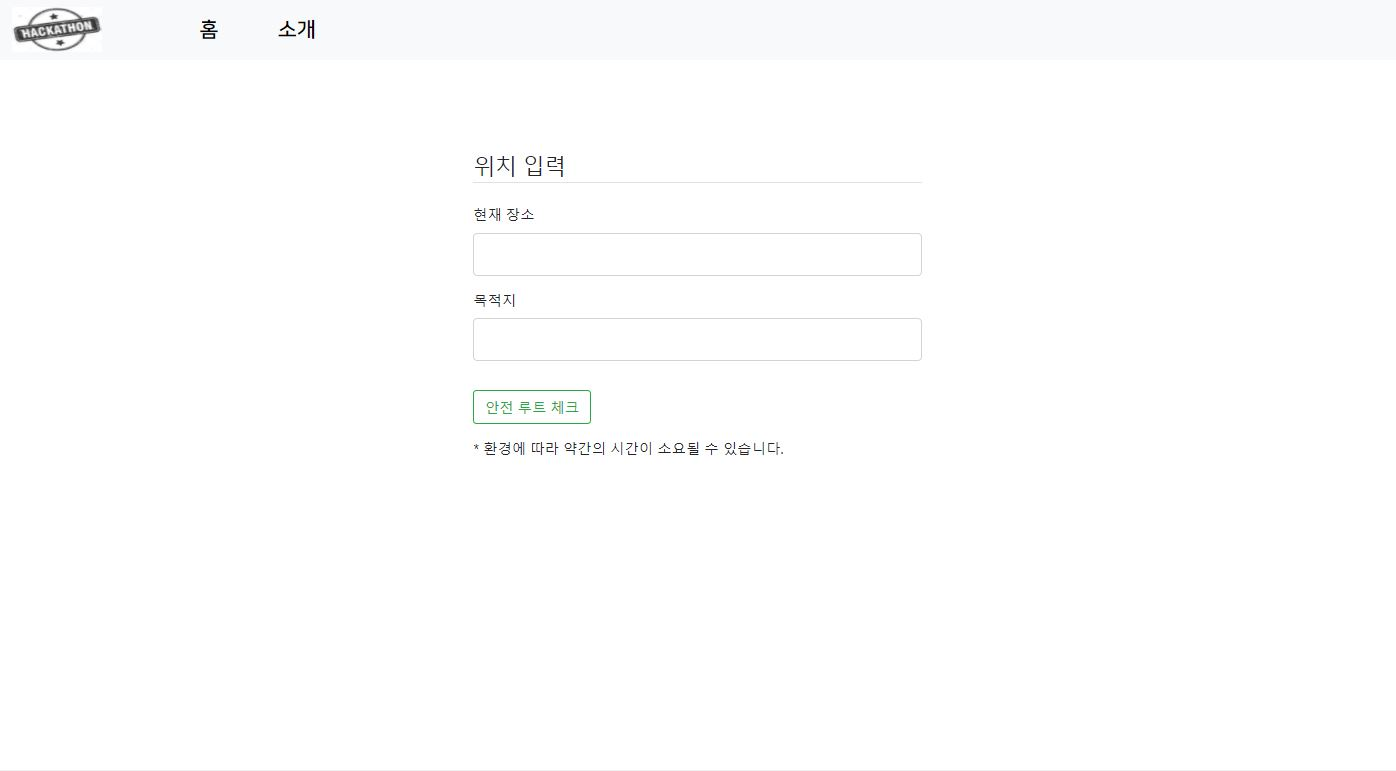



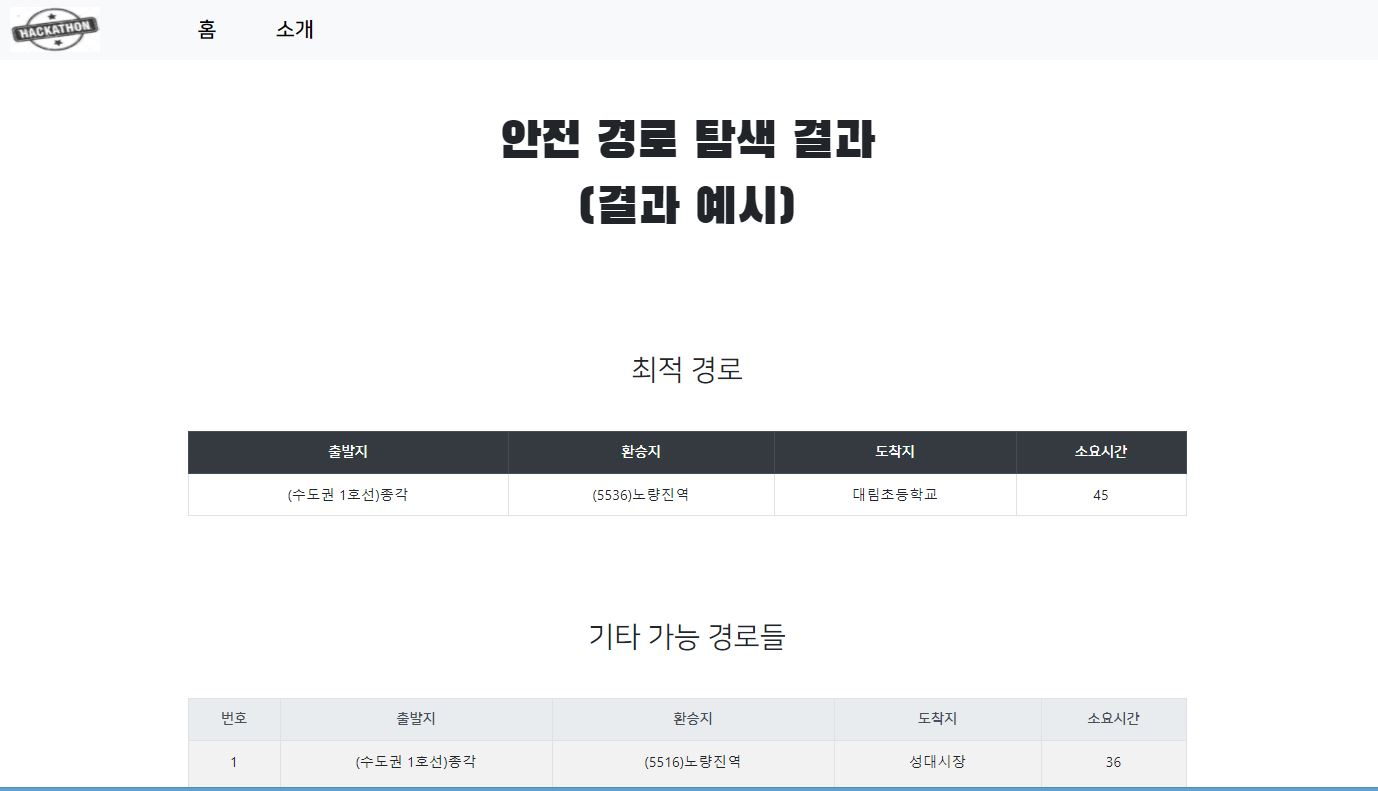

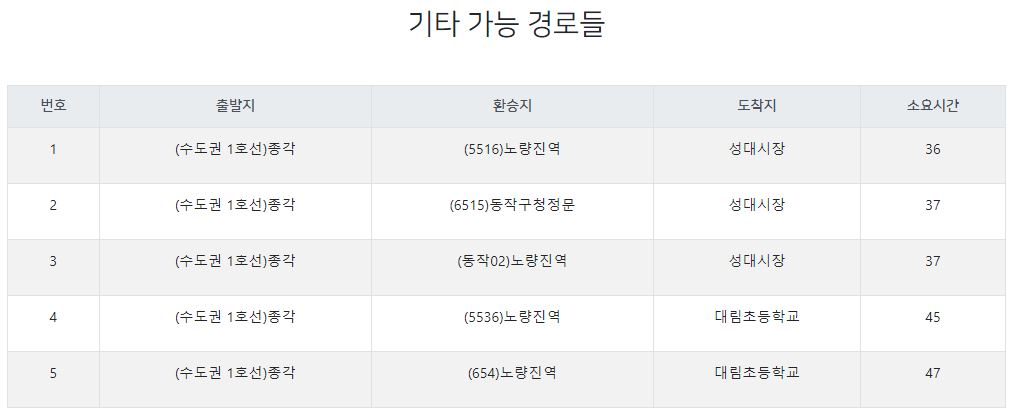

# 신(新)코로나 지표 제작
## 신(新)코로나 지표의 필요성 및 목적

##**현재의 코로나 지역별 코로나 지표는 '후행 지표'이다**.

코로나 사태가 날이 진정될 기미가 보이지 않는다. 확진자는 특정 시점을 기준으로 기하급수적으로 늘어났으며, 현재 코로나 사회적 거리두기 3단계에 준하는 조치인 2.5단계를 실시하고 있다. 그로 인해 경제에도 큰 악영향을 미치고 있을 뿐만 아니라 코로나에 대한 국민들의 피로도도 쌓이고 있다.
장기화되는 코로나에 지친 국민들의 피로도를 대변하듯 아직 코로나 사태가 완전히 진정되지 않았음에도 불구하고 여름 대표 휴양지인 속초, 강릉, 양양, 해운대 등의 대표적인 여름 **휴양지에 인파**가 몰리는 사태가 발생했다.

일반적으로 특정 지역의 코로나 위험도를 판단할 때, 해당 지역의 코로나 확진자 수를 기준으로 판단한다. 하지만 현재 코로나의 경우에는 **실제 위험에 노출되어 감염된 시점에서 확진까지 일반적으로 약 5일 정도가 소요**되기 때문에 현재 확진자는 현재의 위험도를 완벽히 설명하는 것이 아니라 약 5일전의 위험도를 설명하는 것이라고 이해할 수 있다. **그러므로 특정 지역의 코로나 위험도를 판단할 때 단순 확진자 뿐만 아니라 지역적 특성을 나타내는 각종 지표들을 이용해 특정 지역의 현재 위험도를 표현할 수 있는 보완된 신(新)코로나 지표가 필요하다.** 




## 모델링 설계 과정

### 1. 모델의 현재 지표로 판단한 위험도가 몇일의 간격(적절한 lag 변수 값)을 두고 나타나는지 파악한다.
  - 다중선형회귀 분석은 독립변수나 종속변수 중 최소한 하나는 정규분포의 형태를 띄어야 하기 때문에 코로나 확진자 지표의 자연로그 함수를 사용하여 정규분포 형태로 변환하였다.
  - 한국 기준 코로나 증상발현시간은 약 4일이므로 lag 변수를 5일, 7일, 10일로 설정해서 각각 데이터 셋을 만든다.
  - 6월 10일을 기준으로 6월 15일, 6월 17일, 6월 20일을 만든다.
  - 차례대로 다중회귀분석을 실시하여, 가장 적절한 lag변수를 찾는다.
  

#### 1. 분포확인 및 로그 변환

- 데이터 불러오기 및 확인

In [ ]:
data = pd.read_csv("regression123.csv")
data = data[['city','market', 'res', 'ele_cnt', 'kind_cnt','uni_cnt', 'eld_p_r', 'eld_a_r','aca_r','6_10','6_15']]
data.head()

,city,market,res,ele_cnt,kind_cnt,uni_cnt,eld_p_r,eld_a_r,aca_r,6_10,6_15
0,강남구,49,11638,33,38,0,13.17,4.3,4.18,78,78
1,강동구,25,5158,27,32,0,14.55,5.4,1.54,31,33
2,강북구,23,4054,14,21,0,19.49,8.5,0.67,20,23
3,강서구,27,6110,36,56,1,14.39,5.7,1.17,62,69
4,관악구,23,4996,22,33,1,15.12,4.9,0.89,69,77


- 종속변수의 분포 확인 후 로그함수 사용하여 변환

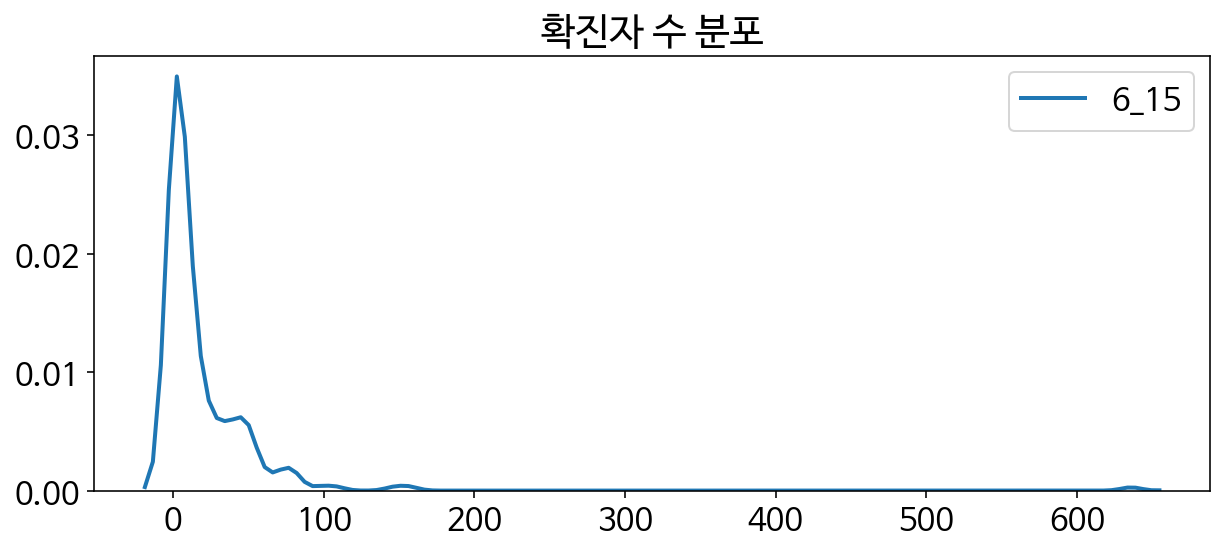

In [ ]:
sns.kdeplot(data['6_15'])
plt.title("확진자 수 분포")
plt.show()

- 로그변환 후 분포 그려보면 정규분포와 비슷한 형태를 띄는 것을 확인할 수 있다.

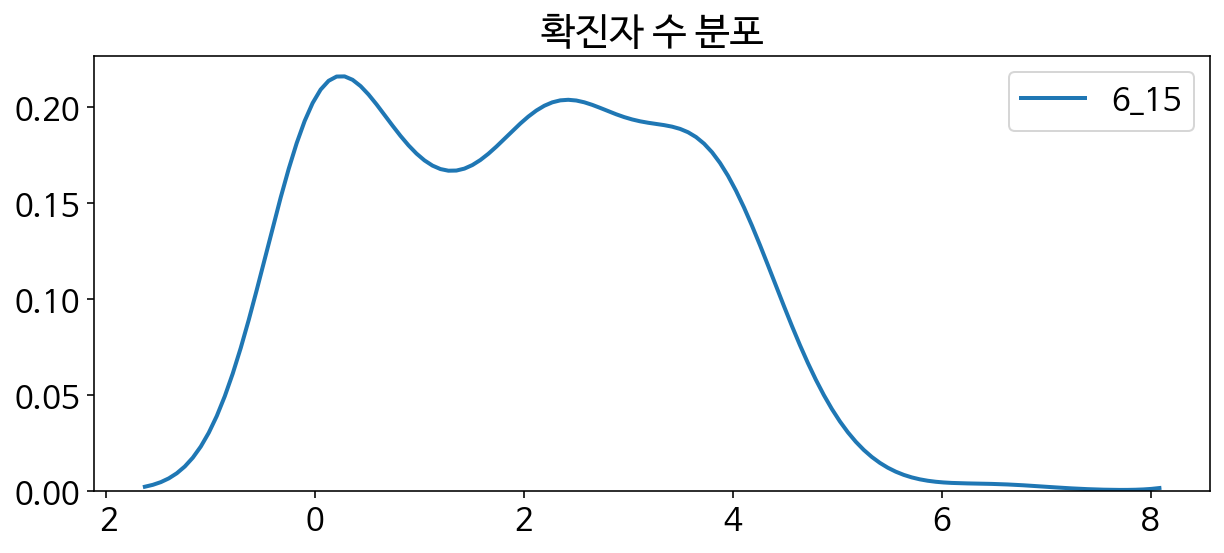

In [ ]:
sns.kdeplot(np.log1p(data['6_15']))
plt.title("확진자 수 분포")
plt.show()

- 확진자 수를 모두 로그변환 후 변수들의 값의 범위가 제각각이므로 변수 스케일링을 실시한다. 변수들의 값을 0~1사이로 스케일링을 시키기 위해 Maxscaler를 사용한다.
- 그 이후, 상관분석을 실시하면 아래처럼 유의미한 변수가 포진되어 있는 것을 확인할 수 있다.

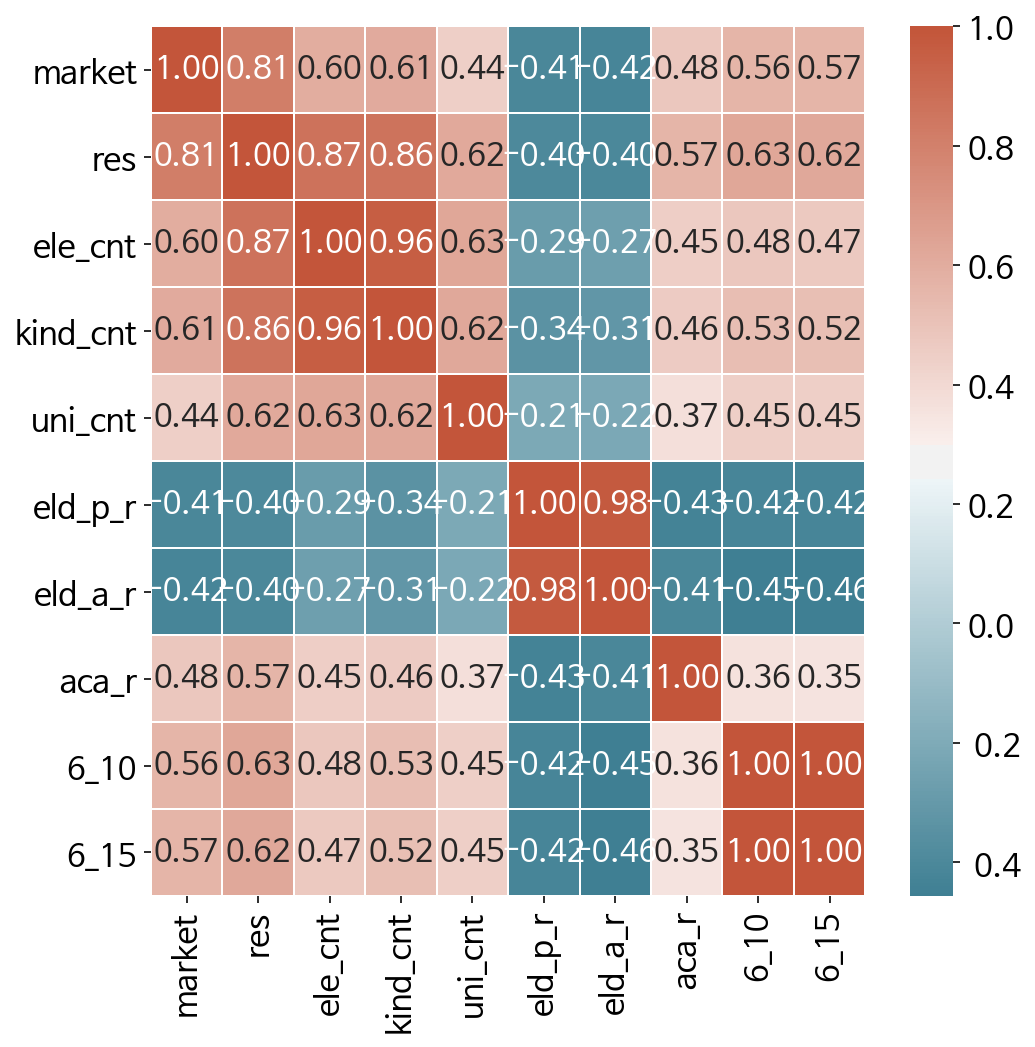

In [ ]:
#스케일링 함수 정의
scaler = MaxAbsScaler()
#확진자 수 로그 변환
data['6_10'] = np.log1p(data['6_10'])
data['6_15'] = np.log1p(data['6_15'])
data = data.drop(['city'],axis=1)
data[data.columns.values[:]] = scaler.fit_transform(data[data.columns.values[:]])
plt.figure(figsize=(8,8))
sns.heatmap(data = data.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap=sns.diverging_palette(220,20,as_cmap=True))

#### 2. lag 변수 : 5일 설정 했을 때 오류율 구하기

#### sklearn 라이브러리 사용한 다중선형회귀 모델 구축

- 모델의 학습 및 검증을 위해 7:3의 비율로 Random Sampling을 실시한다.
- 오류율을 나타내는 지표로 MSE를 사용하여 검증을 실시한다. 
- 모델의 일반적인 성능을 측정하기 위해 10번을 테스트 하였으며, 10개의 MSE 평균을 산출하였다.
- lag 변수를 5로 설정했을 때 평균적인 MSE 값은 0.0008308430347041091로 측정되었다.

In [ ]:
#열이름 가져오기.
cols = list(data.columns) 
#독립변수 열이름.
x_cols = cols[:-1] 
#종속변수 열이름
y_col = cols[-1] 
#매번 모델 성능을 측정할 리스트 생성
score = []
for i in range(10) :
  #train/test split (70 : 30) 
  train_set, test_set = train_test_split(data, test_size = 0.3) 
  #모델 생성 및 학습
  model = LinearRegression() 
  model.fit(X = train_set[x_cols], y = train_set[y_col]) 
  #모델을 통한 예측
  y_pred = model.predict(X=test_set[x_cols]) 

  #정답 
  Y = test_set[y_col] 
  #MSE산출 및 score 리스트에 추가
  mse = mean_squared_error(y_true = Y, y_pred = y_pred) 
  score.append(mse)
#10번의 MSE의 평균 값 산출
final_score = {'lag : 5' :sum(score) / len(score)}
final_score

{'lag : 5': 0.0004899949452371354}

#### 3. lag 변수 : 7일 설정 했을 때 오류율 구하기
- 6월 17일 확진자를 종속변수로 설정한다.
- lag : 7로 설정했을 때 MSE의 평균은 0.04758890407732465임을 알 수 있다.

In [ ]:
data = pd.read_csv("regression123.csv")
data = data[['city','market', 'res', 'ele_cnt', 'kind_cnt','uni_cnt', 'eld_p_r', 'eld_a_r','aca_r','6_10','6_17']]
#스케일링 함수 정의
scaler = MaxAbsScaler()
#확진자 수 로그 변환
data['6_10'] = np.log1p(data['6_10'])
data['6_17'] = np.log1p(data['6_17'])
data = data.drop(['city'],axis=1)
#열이름 가져오기.
cols = list(data.columns) 
#독립변수 열이름.
x_cols = cols[:-1] 
#종속변수 열이름
y_col = cols[-1] 
#매번 모델 성능을 측정할 리스트 생성
score = []
for i in range(10) :
  
  #train/test split (70 : 30) 
  train_set, test_set = train_test_split(data, test_size = 0.3) 
  
  #모델 생성 및 학습
  model = LinearRegression() 
  model.fit(X = train_set[x_cols], y = train_set[y_col]) 
  
  #모델을 통한 예측
  y_pred = model.predict(X=test_set[x_cols]) 
  
  #정답 
  Y = test_set[y_col] 
  
  #MSE산출 및 score 리스트에 추가
  mse = mean_squared_error(y_true = Y, y_pred = y_pred) 
  score.append(mse)

#10번의 MSE의 평균 값 산출
mean_score = sum(score) / len(score)
final_score['lag : 7'] = mean_score
final_score

{'lag : 5': 0.0004899949452371354, 'lag : 7': 0.03491303263434539}

#### 4. lag 변수 : 10일 설정 했을 때 오류율 구하기
- 6월 20일 확진자를 종속변수로 설정한다.
- lag : 10로 설정했을 때 MSE의 평균은 0.03313380898042781임을 알 수 있다.

In [ ]:
data = pd.read_csv("regression123.csv")
data = data[['city','market', 'res', 'ele_cnt', 'kind_cnt','uni_cnt', 'eld_p_r', 'eld_a_r','aca_r','6_10','6_20']]
#스케일링 함수 정의
scaler = MaxAbsScaler()
#확진자 수 로그 변환
data['6_10'] = np.log1p(data['6_10'])
data['6_20'] = np.log1p(data['6_20'])
data = data.drop(['city'],axis=1)
#열이름 가져오기.
cols = list(data.columns) 
#독립변수 열이름.
x_cols = cols[:-1] 
#종속변수 열이름
y_col = cols[-1] 
#매번 모델 성능을 측정할 리스트 생성
score = []
for i in range(10) :
  
  #train/test split (70 : 30) 
  train_set, test_set = train_test_split(data, test_size = 0.3) 
  
  #모델 생성 및 학습
  model = LinearRegression() 
  model.fit(X = train_set[x_cols], y = train_set[y_col]) 
  
  #모델을 통한 예측
  y_pred = model.predict(X=test_set[x_cols]) 
  
  #정답 
  Y = test_set[y_col] 
  
  #MSE산출 및 score 리스트에 추가
  mse = mean_squared_error(y_true = Y, y_pred = y_pred) 
  score.append(mse)

#10번의 MSE의 평균 값 산출
mean_score = sum(score) / len(score)
final_score['lag : 10'] = mean_score
final_score

{'lag : 10': 0.03126125343233835,
 'lag : 5': 0.0004899949452371354,
 'lag : 7': 0.03491303263434539}

### lag = 5일이 가장 유효한 지표임이 밝혀졌다.

### 2. 모델의 유효한 변수 추출
- lag 변수는 5로 밝혀졌으므로, 6월 15일 데이터를 독립변수, 6월 20일 데이터를 종속변수로 설정하여 모델을 검증한다.
- 다중선형회귀분석에서 독립변수간 다중공선성 문제 해결 및 유효하지 않는 변수를 제거하기 위해 Backward Elimination 방법을 사용해 적절한 변수를 선택한다.
- p-value가 가장 높게 나온 uni_cnt(대학교 수), market(대형점포 수) 변수를 제거한다.

In [ ]:
data = pd.read_csv("regression123.csv")
data = data[['market', 'res', 'ele_cnt', 'kind_cnt','uni_cnt', 'eld_p_r', 'eld_a_r','aca_r','6_15','6_20']]
scaler = MaxAbsScaler()
#변수 이름 재설정
data['patient'] = np.log1p(data['6_15'])
data['lag_patient'] = np.log1p(data['6_20'])
data = data.drop(['6_15','6_20'],axis=1)
data[data.columns.values[:]] = scaler.fit_transform(data[data.columns.values[:]])
result = sm.ols(formula = 'lag_patient ~ market+res+	ele_cnt+	kind_cnt+	uni_cnt+	eld_p_r+	eld_a_r+ aca_r + patient', data = data).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            lag_patient   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     1446.
Date:                Fri, 04 Sep 2020   Prob (F-statistic):          2.58e-186
Time:                        09:00:55   Log-Likelihood:                 468.52
No. Observations:                 224   AIC:                            -917.0
Df Residuals:                     214   BIC:                            -882.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0244      0.012      2.001      0.047       0.000       0.048
market        -0.0012      0.020     -0.057      0.955      -0.041       0.039
res            0.0647      0.042      1.557      0.121      -0.017       0.147
ele_cnt       -0.0678      0.048     -1.426      0.155      -0.161       0.026
kind_cnt       0.0391      0.044      0.888      0.375      -0.048       0.126
uni_cnt       -0.0015      0.015     -0.103      0.918      -0.031       0.028
eld_p_r        0.0364      0.049      0.738      0.461      -0.061       0.133
eld_a_r       -0.0605      0.044     -1.386      0.167      -0.147       0.026
aca_r          0.0027      0.018      0.149      0.882      -0.033       0.039
patient        0.9621      0.012     78.638      0.000       0.938       0.986
==============================================================================
Omnibus:                      233.730   Durbin-Watson:                   1.624
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6449.580
Skew:                           4.243   Prob(JB):                         0.00
Kurtosis:                      27.880   Cond. No.                         45.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- p-value가 가장 높게 나온 uni_cnt(대학교 수), market(대형점포 수) 변수를 제거한다.

In [ ]:
data = data.drop(['uni_cnt','market'],axis=1)
result = sm.ols(formula = 'lag_patient ~ kind_cnt+eld_p_r+res+	ele_cnt+	eld_a_r+ aca_r + patient', data = data).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            lag_patient   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     1876.
Date:                Fri, 04 Sep 2020   Prob (F-statistic):          1.38e-189
Time:                        09:00:55   Log-Likelihood:                 468.52
No. Observations:                 224   AIC:                            -921.0
Df Residuals:                     216   BIC:                            -893.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0245      0.012      2.053      0.041       0.001       0.048
kind_cnt       0.0392      0.044      0.896      0.371      -0.047       0.125
eld_p_r        0.0361      0.049      0.744      0.458      -0.060       0.132
res            0.0630      0.031      2.005      0.046       0.001       0.125
ele_cnt       -0.0680      0.047     -1.462      0.145      -0.160       0.024
eld_a_r       -0.0603      0.043     -1.396      0.164      -0.146       0.025
aca_r          0.0026      0.018      0.143      0.886      -0.033       0.038
patient        0.9618      0.012     79.998      0.000       0.938       0.986
==============================================================================
Omnibus:                      234.108   Durbin-Watson:                   1.625
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6493.224
Skew:                           4.252   Prob(JB):                         0.00
Kurtosis:                      27.968   Cond. No.                         44.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- p-value가 가장 높게 나온 aca_r(학원 비율), eld_p_r(노인비율) 변수를 제거한다.

In [ ]:
data = data.drop(['aca_r','eld_p_r'],axis=1)
result = sm.ols(formula = 'lag_patient ~ kind_cnt+res+	ele_cnt+	eld_a_r + patient', data = data).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            lag_patient   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     2644.
Date:                Fri, 04 Sep 2020   Prob (F-statistic):          6.89e-193
Time:                        09:00:55   Log-Likelihood:                 468.23
No. Observations:                 224   AIC:                            -924.5
Df Residuals:                     218   BIC:                            -904.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0304      0.007      4.278      0.000       0.016       0.044
kind_cnt       0.0341      0.043      0.792      0.429      -0.051       0.119
res            0.0674      0.029      2.304      0.022       0.010       0.125
ele_cnt       -0.0675      0.046     -1.456      0.147      -0.159       0.024
eld_a_r       -0.0292      0.010     -2.878      0.004      -0.049      -0.009
patient        0.9631      0.012     81.507      0.000       0.940       0.986
==============================================================================
Omnibus:                      234.888   Durbin-Watson:                   1.624
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6565.789
Skew:                           4.272   Prob(JB):                         0.00
Kurtosis:                      28.110   Cond. No.                         36.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- p-value가 가장 높게 나온 kind_cnt(유치원 수), eld_cnt(노인 수) 변수를 제거한다.

In [ ]:
data = data.drop(['kind_cnt','ele_cnt'],axis=1)
result = sm.ols(formula = 'lag_patient ~ res +	eld_a_r + patient', data = data).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            lag_patient   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     4389.
Date:                Fri, 04 Sep 2020   Prob (F-statistic):          6.37e-196
Time:                        09:00:55   Log-Likelihood:                 466.79
No. Observations:                 224   AIC:                            -925.6
Df Residuals:                     220   BIC:                            -911.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0277      0.007      4.013      0.000       0.014       0.041
res            0.0337      0.016      2.079      0.039       0.002       0.066
eld_a_r       -0.0321      0.010     -3.206      0.002      -0.052      -0.012
patient        0.9668      0.012     83.393      0.000       0.944       0.990
==============================================================================
Omnibus:                      241.045   Durbin-Watson:                   1.601
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7170.808
Skew:                           4.429   Prob(JB):                         0.00
Kurtosis:                      29.265   Cond. No.                         10.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 최종 모델 : p-value 값을 고려했을 때 5일 뒤 코로나 확진자 수에 영향을 미치는 지표는 해당 지역의 **식당 수**, **독거노인 비율**, **현재 확진자 수** 등이 유의미한 영향을 미치는 걸로 분석되었다. 

###3. 지표 검증 

### -  모델로 예측한 6월20일 확진자 수 VS  6월15일 확진자 수로 예측한 6월20일 확진자 수


#### 1. 확진자 수를 통해 예측한 5일 뒤 확진자 수 
- 확진자 수로 예측한 모델의 R_squared = 0.9822688115543752 값이 도출되었다.

In [ ]:
data['x'] = data['patient']
data['y'] = data['lag_patient']
data = data.drop(['res','eld_a_r','lag_patient','patient'],axis = 1)
result = sm.ols(formula = 'y ~ x', data = data).fit()
R_squared = {'Now_patient_prediction R_squred' : result.rsquared}
R_squared

{'Now_patient_prediction R_squred': 0.9822688115543752}

###2. 모델을 통해 5일 뒤 확진자 수 예측과 R-squared 값 도출

- 위의 summary와 같이 R_squared = 0.9835655150159914 값이 도출되었다.

In [ ]:
data = pd.read_csv("regression123.csv")
data = data[['city','res','eld_a_r','6_15','6_20']]
scaler = MaxAbsScaler()
#변수 이름 재설정
data['patient'] = np.log1p(data['6_15'])
data['lag_patient'] = np.log1p(data['6_20'])
data = data.drop(['6_15','6_20'],axis=1)
data[data.columns.values[1:]] = scaler.fit_transform(data[data.columns.values[1:]])
result = sm.ols(formula = 'lag_patient ~ res +	eld_a_r + patient', data = data).fit()
R_squared = {'Model_patient_prediction R_squared' : result.rsquared}
R_squared

{'Model_patient_prediction R_squared': 0.9835655150159914}

##결론 : 확진자 수 기반으로 예측한 위험도 보다 모델을 통해 예측한 위험도가 더욱 신뢰할 수 있는 지표이다. 

## 모델로 예측한 순위로 시군구별 위험도 표시하기

- 데이터를 제공하는 가장 마지막 날짜 기준(6월 30일)으로 위험도 작성
- 상위 25개 시군구는 매우 위험
- 코로나 점수 상위 26위 ~ 199위 시군구는 50개씩 Split해 위험, 보통, 비교적 안전, 안전으로 재분류

In [ ]:
data = pd.read_csv("regression123.csv")
data = data[['city','res','eld_a_r','6_30']]
data['patient'] = np.log1p(data['6_30'])
data = data.drop(['6_30'],axis=1)
data[data.columns.values[1:]] = scaler.fit_transform(data[data.columns.values[1:]])
#모델을 통한 위험도 값 예측
prediction = result.predict(data.iloc[:,1:])
prediction

0      0.706519
1      0.566309
2      0.505688
3      0.694436
4      0.739088
         ...   
219    0.105516
220    0.110175
221    0.445822
222    0.379496
223    0.492752
Length: 224, dtype: float64

In [ ]:
#예측 값 column으로 추가
data['prediction'] = prediction
#분류 column생성
data['classification'] = 0
#예측 값 정렬
data= data.sort_values(by='prediction' ,ascending=False)
#예측 값을 기반으로 classification
for i in range(len(data)):
  #상위 25위 도시 매우 위험
  if (data.iloc[i,4] >= data.iloc[24,4]):
    data.iloc[i,5] = "매우 위험"
  #상위 26~75위 도시 위험
  elif (data.iloc[i,4] >= data.iloc[74,4]):
    data.iloc[i,5] = "위험"
  #상위 76 ~ 125위 도시 보통
  elif (data.iloc[i,4] >= data.iloc[124,4]):
    data.iloc[i,5] = "보통"
  #상위 126 ~ 175위 도시 비교적 안전
  elif (data.iloc[i,4] >= data.iloc[174,4]):
    data.iloc[i,5] = "비교적 안전"
  else : 
  #하위 50개 도시 안전
    data.iloc[i,5] = "안전"

In [ ]:
#상위 5개 도시 출력
data.head(5)

,city,res,eld_a_r,patient,prediction,classification
191,경산시,0.245086,0.874494,1.000000,0.974720,매우 위험
72,성남시,0.558394,0.259109,0.798241,0.809951,매우 위험
75,부천시,0.516491,0.234818,0.788137,0.799547,매우 위험
4,관악구,0.275095,0.198381,0.732814,0.739088,매우 위험
131,천안시,0.603766,0.473684,0.728688,0.737358,매우 위험


In [ ]:
#하위 5개 도시 출력
data.tail(5)

,city,res,eld_a_r,patient,prediction,classification
179,완도군,0.056109,0.890688,0.0,0.001016,안전
171,장흥군,0.039700,0.878543,0.0,0.000852,안전
165,담양군,0.048290,0.910931,0.0,0.000104,안전
168,고흥군,0.060514,0.963563,0.0,-0.001171,안전
167,구례군,0.031882,0.991903,0.0,-0.003045,안전


## 대표적인 도시 4개의 위험도 출력하기
#### - 강남구, 노원구, 대전대덕구, 부산사상구

- 서울 강남구는 '매우 위험'으로 분류되었다.
- 서울 노원구는  '위험'으로 분류되었다.
- 대전 대덕구는 '보통'으로 분류되었다.
- 부산 사상구는 '비교적 안전'으로 분류되었다.

In [ ]:
#유동인구가 많은 강남구 위험도 출력
k=0
k1=0
k2=0
k3=0
k4=0
for i in range(len(data)) :
  if (data.iloc[i,0] =="강남구"):
    k=i
  elif (data.iloc[i,0] == "노원구"):
    k1 = i
  elif (data.iloc[i,0] == "대전대덕구"):
    k2 = i
  elif (data.iloc[i,0] == "부산사상구"):
    k3 = i

city=[]
city.append(data.iloc[k,5])
city.append(data.iloc[k1,5])
city.append(data.iloc[k2,5])
city.append(data.iloc[k3,5])
city

['매우 위험', '위험', '보통', '비교적 안전']

# 결론

* ### 프로젝트 개괄
   - 코로나19의 위협은 백신이 등장하지 않는다면 오랜 시간 계속될 것이다. 그렇다면 우리는 확진자 수를 줄이기 위한 의료적인 방법에만 의존하는 것이 아닌 다른 방법을 고려해야 한다는 것이 이번 프로젝트의 시작이었다.


* ### 지역별 코로나 위험지표 회귀 모델 제작
   - 지역별 회귀모델을 제작하며 ‘현재의 확진자가 과연 몇일 뒤의 확진자를 대변할 수 있는가?’ 라는 의학적으로 접근해온 문제를 통계적으로 접근하며 사용자들에게 실질적으로 현 상황의 위험도를 나타낼 수 있도록 진행하였다. 이 점이 통계적으로 유의미한 결과를 가짐으로써 모델의 완성에 큰 도움이 되었지만 각 지역이 가지고 있던 변수를 활용해 더 좋은 모델을 만들 수 있었다. **이 점에서 우리가 앞으로 더 나은 선행지표를 만들고자 한다면 코로나19에 많은 영향을 미쳤을 것이라 짐작할 수 있는 변수를 넣어 분석을 진행할 수 있을 것이고, 또 다른 변수를 찾아낼 수 있는 모델의 첫걸음에 도달한 것이다.**


* ### 대중교통 안전경로 추천 프로세스 제작
   - 길찾기 모델에 있어서는 무엇보다 시민들에게 가장 효율적으로 경로를 제공할 수 있는 방법에 대해 생각했다. 초기 모델의 목적처럼 서울 시민들을 위한 안전한 경로를 계산하기 위해 많은 지표를 제작하고, 데이터를 사용했지만 정작 시민들에게 다가갈 수 없으면 쓰임받기 어려울 것이고 시민들의 선택의 폭은 우리의 목적과 반대로 최단시간, 최단경로에만 집중될 것이기 때문이다. 따라서 웹에서 시민들이 쉽게 접근할 수 있는 상황을 구축하는 것이 최우선 과제였다. 정량적인 웹에 대한 기대효과는 감히 계산하기 어렵지만 그 무엇보다 시민들이 쉽게 접근해서 정보를 알아볼 수 있는 플랫폼을 만들었다는 점에서 초기의 목적을 달성했다고 생각한다. 
현재 실질적 치료에 대한 많은 연구가 진행중이지만 **교통에서의 안전한 이동**을 시민들에게 제공한다는 목적을 가진 우리의 프로젝트를 시작으로 코로나19에 대한 시민들의 매일 아침, 저녁의 출.퇴근, 등.하교에 대한 두려움이 조금이나마 해소되었으면 한다.
